# Tutorial 1: Discovering the Rescorla-Wagner Model

This tutorial teaches how to use SPICE to discover the Rescorla-Wagner model directly from data.

First, we will train the precoded RNN already setup for the Rescorla-Wagner case. This will allow us to see the training process, its inputs and outputs and performance plots. Then, you will learn how to implement this model as a custom RNN.

## 1. Data generation
First, we simulate a synthetic dataset from a Q-learning agent performing the two-armed bandit task.

In such bandit tasks the participant has to choose between several options across many trials and receives a reward $r$ each time after selecting one of them.

This reward is based on a reward probability $p(r)$.

In some experiments the reward probabilities of the different options are fixed and in others they have a more dynamic nature.

In our case, the reward probabilities are going to change trial-by-trial randomly based on a drift rate $\sigma$ according to

$p(r;t+1) \leftarrow p(r;t) + d$ with $d \sim \mathcal{N}(0, \sigma)$,

where $d$ is the current drift.

Let's set up the environment first.

In [1]:
import numpy as np
import torch

np.random.seed(42)
torch.manual_seed(42)

In [2]:
from spice.resources.bandits import BanditsDrift

Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n_actions = 2
sigma = 0.2

environment = BanditsDrift(sigma=sigma, n_actions=n_actions)

Let's see how the reward probabilities of the arms change across trials

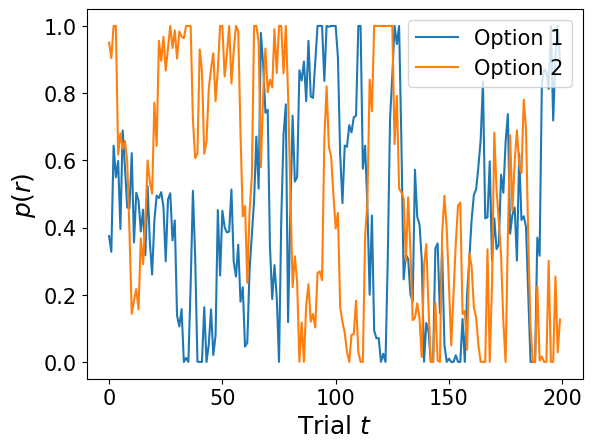

In [4]:
import numpy as np
import matplotlib.pyplot as plt

n_trials = 200
reward_probabilities = np.zeros((n_trials, n_actions))

for index_trials in range(n_trials):
    reward_probabilities[index_trials] = environment.reward_probs
    environment.step(choice=0)

for index_action in range(n_actions):
    plt.plot(reward_probabilities[..., index_action], label=f'Option {index_action+1}')
plt.legend()
plt.xlabel(r'Trial $t$')
plt.ylabel(r'$p(r)$')
plt.show()

Great! After setting up the environment, we can now go on to set up our participant!

The agent's behavior is defined by its parameters. These parameters are set once in the beginning but you can also draw new parameters from a distribution for each new session (i.e. performing $t$ trials).

Let's begin with the simpler case first and keep the parameters fixed for all trials.

We are going to set up a simple Rescorla-Wagner model which has only a learning rate $\alpha$ and an inverse noise temperature $\beta_{reward}$ and generate a dataset with it.

In [5]:
from spice.resources.bandits import AgentQ, create_dataset

agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.3,
)

dataset, _, _ = create_dataset(agent=agent, environment=environment, n_trials=100, n_sessions=100)

Creating dataset...


100%|██████████| 100/100 [00:00<00:00, 319.14it/s]


Let the agent perform now the task and track how the agent's internal believes change across trials!

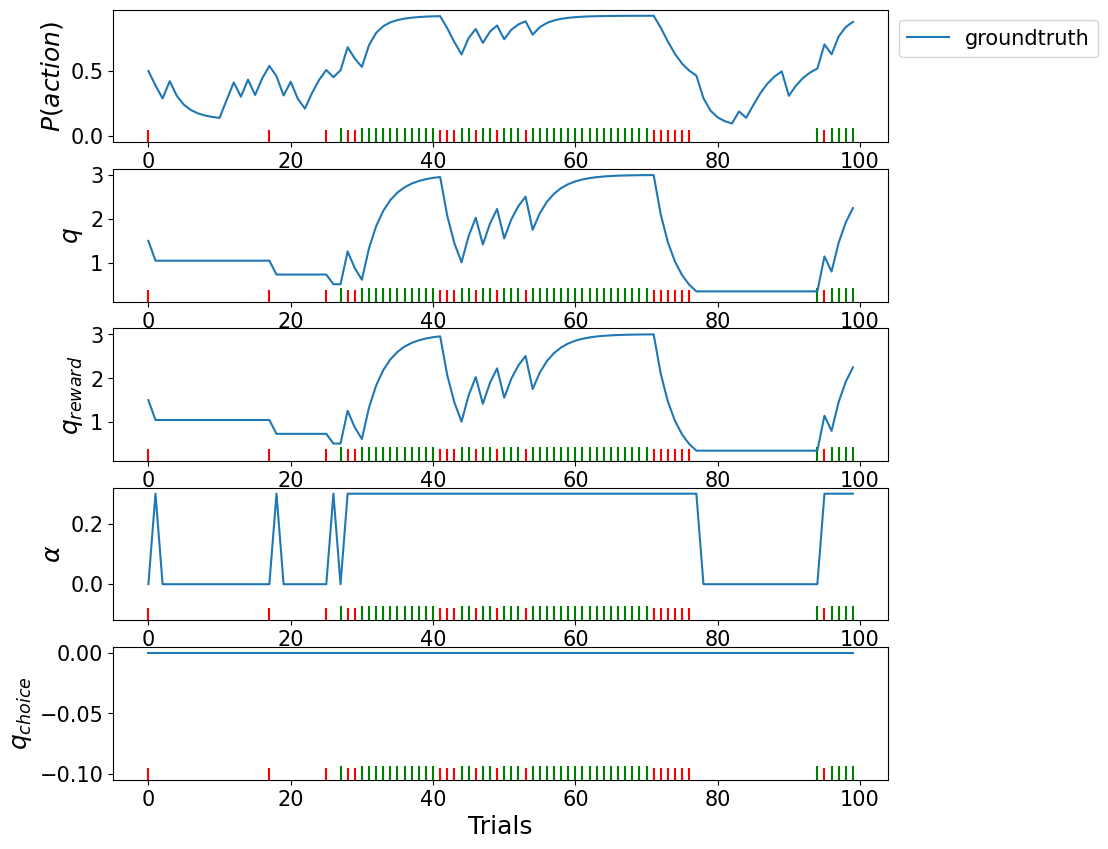

In [6]:
from spice.utils.plotting import plot_session

fig, axs = plot_session(agents = {'groundtruth': agent}, experiment=dataset.xs[0])
plt.show()

The green and red ticks at the bottom mark whenever option 1 was chosen and rewarded/not rewarded.

You can take a look at the experiment results either in dataset (which is used for training the RNN) or in the experiments (which is a list of performed sessions; more human-readable)


In [7]:
print('Inputs (choice item 1 selected; choice item 2 selected; reward 1; reward 2; session id):')
print(dataset.xs)

print('Targets (next choice):')
print(dataset.ys)

Inputs (choice item 1 selected; choice item 2 selected; reward 1; reward 2; session id):
tensor([[[ 1.,  0.,  0., -1.,  0.],
         [ 0.,  1., -1.,  1.,  0.],
         [ 0.,  1., -1.,  0.,  0.],
         ...,
         [ 1.,  0.,  1., -1.,  0.],
         [ 1.,  0.,  1., -1.,  0.],
         [ 1.,  0.,  1., -1.,  0.]],

        [[ 1.,  0.,  0., -1.,  1.],
         [ 0.,  1., -1.,  1.,  1.],
         [ 0.,  1., -1.,  1.,  1.],
         ...,
         [ 1.,  0.,  1., -1.,  1.],
         [ 1.,  0.,  1., -1.,  1.],
         [ 1.,  0.,  1., -1.,  1.]],

        [[ 1.,  0.,  0., -1.,  2.],
         [ 0.,  1., -1.,  1.,  2.],
         [ 0.,  1., -1.,  1.,  2.],
         ...,
         [ 0.,  1., -1.,  1.,  2.],
         [ 0.,  1., -1.,  1.,  2.],
         [ 0.,  1., -1.,  1.,  2.]],

        ...,

        [[ 1.,  0.,  1., -1., 97.],
         [ 1.,  0.,  1., -1., 97.],
         [ 1.,  0.,  1., -1., 97.],
         ...,
         [ 0.,  1., -1.,  0., 97.],
         [ 0.,  1., -1.,  0., 97.],
       

Now that we have our data, we can proceed to setup our RNN and train it!

## 2. Using the precoded Rescorla-Wagner RNN

First we will use the precoded RNN for discovering models like the Rescorla-Wagner model directly from data. We use SpiceEstimator to fit this RNN to the data we simulated above. The RNN modules and SPICE configuration are predetermined for discovering the Rescorla-Wagner model.

If `spice_participant_id` is not specified (set to `None`) then the SPICE model is fit to all participants. However, the fitting procedure would take a while. Instead, we set `spice_participant_id=0` to extract the SPICE model for participant 0.

In [8]:
from spice.estimator import SpiceEstimator
from spice.precoded import RescorlaWagnerRNN, RESCOLA_WAGNER_CONFIG

spice_estimator = SpiceEstimator(
    rnn_class=RescorlaWagnerRNN,
    spice_config=RESCOLA_WAGNER_CONFIG,
    learning_rate=1e-2,
    epochs=1024,
    verbose=True,
)

spice_estimator.fit(dataset.xs, dataset.ys)


Training the RNN...
Epoch 1/1024 --- L(Train): 0.7680403; Time: 0.04s; Convergence: 6.16e-01
Epoch 2/1024 --- L(Train): 0.7648043; Time: 0.04s; Convergence: 3.10e-01
Epoch 3/1024 --- L(Train): 0.7622932; Time: 0.03s; Convergence: 1.56e-01
Epoch 4/1024 --- L(Train): 0.7607337; Time: 0.04s; Convergence: 7.88e-02
Epoch 5/1024 --- L(Train): 0.7596966; Time: 0.04s; Convergence: 3.99e-02
Epoch 6/1024 --- L(Train): 0.7588133; Time: 0.04s; Convergence: 2.04e-02
Epoch 7/1024 --- L(Train): 0.7579823; Time: 0.04s; Convergence: 1.06e-02
Epoch 8/1024 --- L(Train): 0.7570097; Time: 0.03s; Convergence: 5.79e-03
Epoch 9/1024 --- L(Train): 0.7558771; Time: 0.04s; Convergence: 3.46e-03
Epoch 10/1024 --- L(Train): 0.7546263; Time: 0.04s; Convergence: 2.36e-03
Epoch 11/1024 --- L(Train): 0.7533101; Time: 0.04s; Convergence: 1.84e-03
Epoch 12/1024 --- L(Train): 0.7519745; Time: 0.04s; Convergence: 1.59e-03
Epoch 13/1024 --- L(Train): 0.7506552; Time: 0.03s; Convergence: 1.45e-03
Epoch 14/1024 --- L(Train)

  0%|          | 0/100 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  1%|          | 1/100 [00:00<00:30,  3.30it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 7.0750e+00 ... 2.6474e-01 ... 1.6299e-01 ... 7.2406e+00
        10 ... 7.0847e+00 ... 2.5278e-01 ... 1.6349e-01 ... 7.2507e+00
        20 ... 7.0932e+00 ... 2.5308e-01 ... 1.6249e-01 ... 7.2582e+00
        30 ... 7.1041e+00 ... 2.5335e-01 ... 1.6164e-01 ... 7.2682e+00
        40 ... 7.1159e+00 ... 2.5358e-01 ... 1.6093e-01 ... 7.2794e+00
        50 ... 7.1279e+00 ... 2.5378e-01 ... 1.6033e-01 ... 7.2907e+00
        60 ... 7.1393e+00 ... 2.5395e-01 ... 1.5982e-01 ... 7.3016e+00
        70 ... 7.1498e+00 ... 2.5410e-01 ... 1.5939e-01 ... 7.3118e+00
        80 ... 7.1595e+00 ... 2.5423e-01 ... 1.5903e-01 ... 7.3210e+00
        90 ... 7.1681e+00 ... 2.5434e-01 ... 1.5873e-01 ... 7.3293e+00
(x_value_reward_chosen)[k+1] = 3.358 1 + 0.665 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  2%|▏         | 2/100 [00:00<00:29,  3.38it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1836e+01 ... 2.5509e-01 ... 1.6100e-01 ... 1.2000e+01
        10 ... 1.1841e+01 ... 2.5208e-01 ... 1.5922e-01 ... 1.2002e+01
        20 ... 1.1849e+01 ... 2.5176e-01 ... 1.5817e-01 ... 1.2010e+01
        30 ... 1.1860e+01 ... 2.5151e-01 ... 1.5727e-01 ... 1.2020e+01
        40 ... 1.1872e+01 ... 2.5131e-01 ... 1.5652e-01 ... 1.2031e+01
        50 ... 1.1884e+01 ... 2.5115e-01 ... 1.5588e-01 ... 1.2043e+01
        60 ... 1.1896e+01 ... 2.5103e-01 ... 1.5534e-01 ... 1.2054e+01
        70 ... 1.1907e+01 ... 2.5093e-01 ... 1.5488e-01 ... 1.2065e+01
        80 ... 1.1917e+01 ... 2.5085e-01 ... 1.5449e-01 ... 1.2074e+01
        90 ... 1.1926e+01 ... 2.5078e-01 ... 1.5416e-01 ... 1.2083e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  3%|▎         | 3/100 [00:00<00:28,  3.38it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1835e+01 ... 2.5604e-01 ... 1.6118e-01 ... 1.1999e+01
        10 ... 1.1840e+01 ... 2.5229e-01 ... 1.5930e-01 ... 1.2002e+01
        20 ... 1.1848e+01 ... 2.5195e-01 ... 1.5824e-01 ... 1.2009e+01
        30 ... 1.1859e+01 ... 2.5169e-01 ... 1.5735e-01 ... 1.2019e+01
        40 ... 1.1871e+01 ... 2.5148e-01 ... 1.5659e-01 ... 1.2030e+01
        50 ... 1.1883e+01 ... 2.5131e-01 ... 1.5595e-01 ... 1.2042e+01
        60 ... 1.1895e+01 ... 2.5118e-01 ... 1.5541e-01 ... 1.2053e+01
        70 ... 1.1906e+01 ... 2.5107e-01 ... 1.5495e-01 ... 1.2064e+01
        80 ... 1.1917e+01 ... 2.5098e-01 ... 1.5456e-01 ... 1.2074e+01
        90 ... 1.1926e+01 ... 2.5091e-01 ... 1.5423e-01 ... 1.2082e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  4%|▍         | 4/100 [00:01<00:28,  3.38it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8718e+00 ... 2.5801e-01 ... 1.6537e-01 ... 4.0397e+00
        10 ... 3.8792e+00 ... 2.5089e-01 ... 1.6561e-01 ... 4.0473e+00
        20 ... 3.8876e+00 ... 2.5085e-01 ... 1.6467e-01 ... 4.0548e+00
        30 ... 3.8986e+00 ... 2.5081e-01 ... 1.6387e-01 ... 4.0650e+00
        40 ... 3.9108e+00 ... 2.5078e-01 ... 1.6319e-01 ... 4.0765e+00
        50 ... 3.9231e+00 ... 2.5076e-01 ... 1.6262e-01 ... 4.0882e+00
        60 ... 3.9349e+00 ... 2.5074e-01 ... 1.6213e-01 ... 4.0996e+00
        70 ... 3.9460e+00 ... 2.5072e-01 ... 1.6172e-01 ... 4.1102e+00
        80 ... 3.9561e+00 ... 2.5071e-01 ... 1.6137e-01 ... 4.1200e+00
        90 ... 3.9652e+00 ... 2.5069e-01 ... 1.6108e-01 ... 4.1288e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  5%|▌         | 5/100 [00:01<00:28,  3.34it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.6841e+00 ... 3.0441e-01 ... 1.7501e-01 ... 4.8622e+00
        10 ... 4.7060e+00 ... 2.6051e-01 ... 1.7696e-01 ... 4.8855e+00
        20 ... 4.7152e+00 ... 2.6070e-01 ... 1.7603e-01 ... 4.8938e+00
        30 ... 4.7266e+00 ... 2.6086e-01 ... 1.7526e-01 ... 4.9045e+00
        40 ... 4.7387e+00 ... 2.6100e-01 ... 1.7463e-01 ... 4.9160e+00
        50 ... 4.7505e+00 ... 2.6111e-01 ... 1.7411e-01 ... 4.9272e+00
        60 ... 4.7614e+00 ... 2.6120e-01 ... 1.7368e-01 ... 4.9377e+00
        70 ... 4.7712e+00 ... 2.6127e-01 ... 1.7333e-01 ... 4.9471e+00
        80 ... 4.7798e+00 ... 2.6133e-01 ... 1.7304e-01 ... 4.9555e+00
        90 ... 4.7873e+00 ... 2.6138e-01 ... 1.7280e-01 ... 4.9627e+00
(x_value_reward_chosen)[k+1] = 2.778 1 + 0.723 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  6%|▌         | 6/100 [00:01<00:28,  3.30it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1834e+01 ... 2.5679e-01 ... 1.6131e-01 ... 1.1998e+01
        10 ... 1.1839e+01 ... 2.5245e-01 ... 1.5935e-01 ... 1.2001e+01
        20 ... 1.1847e+01 ... 2.5210e-01 ... 1.5830e-01 ... 1.2008e+01
        30 ... 1.1858e+01 ... 2.5182e-01 ... 1.5740e-01 ... 1.2018e+01
        40 ... 1.1871e+01 ... 2.5160e-01 ... 1.5664e-01 ... 1.2030e+01
        50 ... 1.1883e+01 ... 2.5143e-01 ... 1.5600e-01 ... 1.2041e+01
        60 ... 1.1895e+01 ... 2.5129e-01 ... 1.5546e-01 ... 1.2053e+01
        70 ... 1.1906e+01 ... 2.5117e-01 ... 1.5500e-01 ... 1.2063e+01
        80 ... 1.1916e+01 ... 2.5108e-01 ... 1.5461e-01 ... 1.2073e+01
        90 ... 1.1925e+01 ... 2.5101e-01 ... 1.5428e-01 ... 1.2082e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  7%|▋         | 7/100 [00:02<00:28,  3.22it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1836e+01 ... 2.5541e-01 ... 1.6106e-01 ... 1.1999e+01
        10 ... 1.1840e+01 ... 2.5215e-01 ... 1.5925e-01 ... 1.2002e+01
        20 ... 1.1849e+01 ... 2.5182e-01 ... 1.5819e-01 ... 1.2009e+01
        30 ... 1.1860e+01 ... 2.5157e-01 ... 1.5730e-01 ... 1.2019e+01
        40 ... 1.1872e+01 ... 2.5137e-01 ... 1.5654e-01 ... 1.2031e+01
        50 ... 1.1884e+01 ... 2.5121e-01 ... 1.5590e-01 ... 1.2042e+01
        60 ... 1.1896e+01 ... 2.5108e-01 ... 1.5536e-01 ... 1.2054e+01
        70 ... 1.1907e+01 ... 2.5098e-01 ... 1.5490e-01 ... 1.2064e+01
        80 ... 1.1917e+01 ... 2.5089e-01 ... 1.5452e-01 ... 1.2074e+01
        90 ... 1.1926e+01 ... 2.5083e-01 ... 1.5419e-01 ... 1.2083e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  8%|▊         | 8/100 [00:02<00:28,  3.27it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1833e+01 ... 2.5839e-01 ... 1.6157e-01 ... 1.1997e+01
        10 ... 1.1838e+01 ... 2.5277e-01 ... 1.5946e-01 ... 1.2000e+01
        20 ... 1.1846e+01 ... 2.5239e-01 ... 1.5840e-01 ... 1.2007e+01
        30 ... 1.1857e+01 ... 2.5209e-01 ... 1.5750e-01 ... 1.2017e+01
        40 ... 1.1869e+01 ... 2.5185e-01 ... 1.5674e-01 ... 1.2029e+01
        50 ... 1.1882e+01 ... 2.5166e-01 ... 1.5609e-01 ... 1.2040e+01
        60 ... 1.1894e+01 ... 2.5150e-01 ... 1.5555e-01 ... 1.2052e+01
        70 ... 1.1905e+01 ... 2.5138e-01 ... 1.5508e-01 ... 1.2062e+01
        80 ... 1.1915e+01 ... 2.5128e-01 ... 1.5469e-01 ... 1.2072e+01
        90 ... 1.1924e+01 ... 2.5119e-01 ... 1.5436e-01 ... 1.2081e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  9%|▉         | 9/100 [00:02<00:27,  3.32it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8933e+00 ... 2.5484e-01 ... 1.6905e-01 ... 4.0649e+00
        10 ... 3.8979e+00 ... 2.5240e-01 ... 1.6740e-01 ... 4.0678e+00
        20 ... 3.9063e+00 ... 2.5243e-01 ... 1.6644e-01 ... 4.0753e+00
        30 ... 3.9173e+00 ... 2.5245e-01 ... 1.6564e-01 ... 4.0855e+00
        40 ... 3.9294e+00 ... 2.5247e-01 ... 1.6496e-01 ... 4.0969e+00
        50 ... 3.9417e+00 ... 2.5249e-01 ... 1.6438e-01 ... 4.1086e+00
        60 ... 3.9535e+00 ... 2.5251e-01 ... 1.6389e-01 ... 4.1199e+00
        70 ... 3.9645e+00 ... 2.5252e-01 ... 1.6348e-01 ... 4.1305e+00
        80 ... 3.9745e+00 ... 2.5253e-01 ... 1.6313e-01 ... 4.1401e+00
        90 ... 3.9835e+00 ... 2.5254e-01 ... 1.6284e-01 ... 4.1489e+00
(x_value_reward_chosen)[k+1] = 3.307 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 10%|█         | 10/100 [00:03<00:26,  3.37it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.7134e+00 ... 2.7412e-01 ... 1.7685e-01 ... 4.8930e+00
        10 ... 4.7263e+00 ... 2.5443e-01 ... 1.7782e-01 ... 4.9066e+00
        20 ... 4.7355e+00 ... 2.5458e-01 ... 1.7688e-01 ... 4.9149e+00
        30 ... 4.7469e+00 ... 2.5471e-01 ... 1.7611e-01 ... 4.9256e+00
        40 ... 4.7590e+00 ... 2.5482e-01 ... 1.7547e-01 ... 4.9371e+00
        50 ... 4.7708e+00 ... 2.5491e-01 ... 1.7495e-01 ... 4.9483e+00
        60 ... 4.7818e+00 ... 2.5499e-01 ... 1.7452e-01 ... 4.9588e+00
        70 ... 4.7916e+00 ... 2.5505e-01 ... 1.7416e-01 ... 4.9683e+00
        80 ... 4.8002e+00 ... 2.5510e-01 ... 1.7387e-01 ... 4.9767e+00
        90 ... 4.8077e+00 ... 2.5515e-01 ... 1.7363e-01 ... 4.9839e+00
(x_value_reward_chosen)[k+1] = 2.778 1 + 0.723 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 11%|█         | 11/100 [00:03<00:26,  3.39it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5542e+00 ... 3.1316e-01 ... 1.4593e-01 ... 9.7033e+00
        10 ... 9.5701e+00 ... 2.6890e-01 ... 1.4204e-01 ... 9.7149e+00
        20 ... 9.5776e+00 ... 2.6853e-01 ... 1.4100e-01 ... 9.7213e+00
        30 ... 9.5879e+00 ... 2.6821e-01 ... 1.4010e-01 ... 9.7307e+00
        40 ... 9.5998e+00 ... 2.6794e-01 ... 1.3931e-01 ... 9.7418e+00
        50 ... 9.6122e+00 ... 2.6770e-01 ... 1.3863e-01 ... 9.7535e+00
        60 ... 9.6246e+00 ... 2.6750e-01 ... 1.3804e-01 ... 9.7653e+00
        70 ... 9.6365e+00 ... 2.6733e-01 ... 1.3753e-01 ... 9.7767e+00
        80 ... 9.6478e+00 ... 2.6718e-01 ... 1.3709e-01 ... 9.7876e+00
        90 ... 9.6583e+00 ... 2.6704e-01 ... 1.3670e-01 ... 9.7977e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 12%|█▏        | 12/100 [00:03<00:25,  3.41it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.7188e+01 ... 2.6285e-01 ... 1.6615e-01 ... 1.7357e+01
        10 ... 1.7194e+01 ... 2.5434e-01 ... 1.6385e-01 ... 1.7360e+01
        20 ... 1.7203e+01 ... 2.5403e-01 ... 1.6284e-01 ... 1.7368e+01
        30 ... 1.7214e+01 ... 2.5377e-01 ... 1.6201e-01 ... 1.7379e+01
        40 ... 1.7227e+01 ... 2.5357e-01 ... 1.6131e-01 ... 1.7390e+01
        50 ... 1.7239e+01 ... 2.5340e-01 ... 1.6073e-01 ... 1.7402e+01
        60 ... 1.7250e+01 ... 2.5327e-01 ... 1.6025e-01 ... 1.7413e+01
        70 ... 1.7261e+01 ... 2.5316e-01 ... 1.5984e-01 ... 1.7423e+01
        80 ... 1.7270e+01 ... 2.5307e-01 ... 1.5951e-01 ... 1.7432e+01
        90 ... 1.7279e+01 ... 2.5299e-01 ... 1.5923e-01 ... 1.7440e+01
(x_value_reward_chosen)[k+1] = 3.474 1 + 0.653 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 13%|█▎        | 13/100 [00:03<00:25,  3.36it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5868e+00 ... 2.8084e-01 ... 1.4408e-01 ... 9.7337e+00
        10 ... 9.5963e+00 ... 2.5913e-01 ... 1.4097e-01 ... 9.7399e+00
        20 ... 9.6038e+00 ... 2.5891e-01 ... 1.3994e-01 ... 9.7464e+00
        30 ... 9.6141e+00 ... 2.5873e-01 ... 1.3905e-01 ... 9.7558e+00
        40 ... 9.6259e+00 ... 2.5857e-01 ... 1.3827e-01 ... 9.7668e+00
        50 ... 9.6383e+00 ... 2.5844e-01 ... 1.3760e-01 ... 9.7784e+00
        60 ... 9.6506e+00 ... 2.5832e-01 ... 1.3702e-01 ... 9.7902e+00
        70 ... 9.6625e+00 ... 2.5822e-01 ... 1.3651e-01 ... 9.8016e+00
        80 ... 9.6737e+00 ... 2.5813e-01 ... 1.3607e-01 ... 9.8123e+00
        90 ... 9.6841e+00 ... 2.5806e-01 ... 1.3569e-01 ... 9.8224e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 14%|█▍        | 14/100 [00:04<00:25,  3.36it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8751e+00 ... 2.5474e-01 ... 1.6582e-01 ... 4.0434e+00
        10 ... 3.8811e+00 ... 2.5052e-01 ... 1.6576e-01 ... 4.0494e+00
        20 ... 3.8895e+00 ... 2.5049e-01 ... 1.6481e-01 ... 4.0569e+00
        30 ... 3.9006e+00 ... 2.5047e-01 ... 1.6401e-01 ... 4.0671e+00
        40 ... 3.9127e+00 ... 2.5045e-01 ... 1.6333e-01 ... 4.0785e+00
        50 ... 3.9250e+00 ... 2.5044e-01 ... 1.6275e-01 ... 4.0903e+00
        60 ... 3.9368e+00 ... 2.5043e-01 ... 1.6227e-01 ... 4.1016e+00
        70 ... 3.9479e+00 ... 2.5042e-01 ... 1.6186e-01 ... 4.1122e+00
        80 ... 3.9579e+00 ... 2.5041e-01 ... 1.6151e-01 ... 4.1219e+00
        90 ... 3.9670e+00 ... 2.5040e-01 ... 1.6121e-01 ... 4.1307e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 15%|█▌        | 15/100 [00:04<00:25,  3.30it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.6889e+00 ... 2.9866e-01 ... 1.7528e-01 ... 4.8672e+00
        10 ... 4.7089e+00 ... 2.5971e-01 ... 1.7704e-01 ... 4.8885e+00
        20 ... 4.7181e+00 ... 2.5990e-01 ... 1.7611e-01 ... 4.8968e+00
        30 ... 4.7295e+00 ... 2.6006e-01 ... 1.7534e-01 ... 4.9075e+00
        40 ... 4.7416e+00 ... 2.6020e-01 ... 1.7471e-01 ... 4.9189e+00
        50 ... 4.7534e+00 ... 2.6031e-01 ... 1.7419e-01 ... 4.9302e+00
        60 ... 4.7643e+00 ... 2.6040e-01 ... 1.7376e-01 ... 4.9406e+00
        70 ... 4.7741e+00 ... 2.6048e-01 ... 1.7341e-01 ... 4.9501e+00
        80 ... 4.7827e+00 ... 2.6054e-01 ... 1.7312e-01 ... 4.9584e+00
        90 ... 4.7902e+00 ... 2.6060e-01 ... 1.7288e-01 ... 4.9657e+00
(x_value_reward_chosen)[k+1] = 2.778 1 + 0.723 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 16%|█▌        | 16/100 [00:04<00:25,  3.33it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1835e+01 ... 2.5666e-01 ... 1.6129e-01 ... 1.1998e+01
        10 ... 1.1839e+01 ... 2.5242e-01 ... 1.5934e-01 ... 1.2001e+01
        20 ... 1.1848e+01 ... 2.5207e-01 ... 1.5829e-01 ... 1.2008e+01
        30 ... 1.1859e+01 ... 2.5180e-01 ... 1.5739e-01 ... 1.2018e+01
        40 ... 1.1871e+01 ... 2.5158e-01 ... 1.5663e-01 ... 1.2030e+01
        50 ... 1.1883e+01 ... 2.5141e-01 ... 1.5599e-01 ... 1.2041e+01
        60 ... 1.1895e+01 ... 2.5127e-01 ... 1.5545e-01 ... 1.2053e+01
        70 ... 1.1906e+01 ... 2.5115e-01 ... 1.5499e-01 ... 1.2063e+01
        80 ... 1.1916e+01 ... 2.5106e-01 ... 1.5460e-01 ... 1.2073e+01
        90 ... 1.1925e+01 ... 2.5099e-01 ... 1.5427e-01 ... 1.2082e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 17%|█▋        | 17/100 [00:05<00:24,  3.37it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1835e+01 ... 2.5571e-01 ... 1.6112e-01 ... 1.1999e+01
        10 ... 1.1840e+01 ... 2.5222e-01 ... 1.5927e-01 ... 1.2002e+01
        20 ... 1.1848e+01 ... 2.5189e-01 ... 1.5822e-01 ... 1.2009e+01
        30 ... 1.1859e+01 ... 2.5163e-01 ... 1.5732e-01 ... 1.2019e+01
        40 ... 1.1871e+01 ... 2.5142e-01 ... 1.5657e-01 ... 1.2031e+01
        50 ... 1.1884e+01 ... 2.5126e-01 ... 1.5593e-01 ... 1.2042e+01
        60 ... 1.1896e+01 ... 2.5113e-01 ... 1.5538e-01 ... 1.2053e+01
        70 ... 1.1907e+01 ... 2.5102e-01 ... 1.5493e-01 ... 1.2064e+01
        80 ... 1.1917e+01 ... 2.5094e-01 ... 1.5454e-01 ... 1.2074e+01
        90 ... 1.1926e+01 ... 2.5087e-01 ... 1.5421e-01 ... 1.2083e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 18%|█▊        | 18/100 [00:05<00:24,  3.37it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.6894e+00 ... 2.9815e-01 ... 1.7530e-01 ... 4.8677e+00
        10 ... 4.7092e+00 ... 2.5963e-01 ... 1.7705e-01 ... 4.8888e+00
        20 ... 4.7184e+00 ... 2.5983e-01 ... 1.7611e-01 ... 4.8971e+00
        30 ... 4.7298e+00 ... 2.5999e-01 ... 1.7535e-01 ... 4.9078e+00
        40 ... 4.7419e+00 ... 2.6012e-01 ... 1.7472e-01 ... 4.9192e+00
        50 ... 4.7537e+00 ... 2.6024e-01 ... 1.7420e-01 ... 4.9305e+00
        60 ... 4.7646e+00 ... 2.6033e-01 ... 1.7377e-01 ... 4.9409e+00
        70 ... 4.7744e+00 ... 2.6041e-01 ... 1.7341e-01 ... 4.9504e+00
        80 ... 4.7830e+00 ... 2.6047e-01 ... 1.7312e-01 ... 4.9587e+00
        90 ... 4.7905e+00 ... 2.6052e-01 ... 1.7288e-01 ... 4.9660e+00
(x_value_reward_chosen)[k+1] = 2.778 1 + 0.723 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 19%|█▉        | 19/100 [00:05<00:23,  3.40it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8731e+00 ... 2.5655e-01 ... 1.6556e-01 ... 4.0413e+00
        10 ... 3.8800e+00 ... 2.5074e-01 ... 1.6567e-01 ... 4.0481e+00
        20 ... 3.8884e+00 ... 2.5070e-01 ... 1.6472e-01 ... 4.0556e+00
        30 ... 3.8994e+00 ... 2.5067e-01 ... 1.6392e-01 ... 4.0658e+00
        40 ... 3.9116e+00 ... 2.5065e-01 ... 1.6324e-01 ... 4.0773e+00
        50 ... 3.9239e+00 ... 2.5063e-01 ... 1.6267e-01 ... 4.0890e+00
        60 ... 3.9357e+00 ... 2.5061e-01 ... 1.6218e-01 ... 4.1004e+00
        70 ... 3.9468e+00 ... 2.5060e-01 ... 1.6177e-01 ... 4.1110e+00
        80 ... 3.9568e+00 ... 2.5058e-01 ... 1.6143e-01 ... 4.1208e+00
        90 ... 3.9659e+00 ... 2.5057e-01 ... 1.6113e-01 ... 4.1295e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 20%|██        | 20/100 [00:05<00:23,  3.41it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.6835e+00 ... 3.0520e-01 ... 1.7497e-01 ... 4.8615e+00
        10 ... 4.7056e+00 ... 2.6061e-01 ... 1.7695e-01 ... 4.8852e+00
        20 ... 4.7148e+00 ... 2.6081e-01 ... 1.7602e-01 ... 4.8934e+00
        30 ... 4.7263e+00 ... 2.6097e-01 ... 1.7525e-01 ... 4.9041e+00
        40 ... 4.7384e+00 ... 2.6110e-01 ... 1.7462e-01 ... 4.9156e+00
        50 ... 4.7501e+00 ... 2.6121e-01 ... 1.7410e-01 ... 4.9268e+00
        60 ... 4.7610e+00 ... 2.6130e-01 ... 1.7367e-01 ... 4.9373e+00
        70 ... 4.7708e+00 ... 2.6137e-01 ... 1.7332e-01 ... 4.9468e+00
        80 ... 4.7795e+00 ... 2.6143e-01 ... 1.7303e-01 ... 4.9551e+00
        90 ... 4.7870e+00 ... 2.6149e-01 ... 1.7279e-01 ... 4.9624e+00
(x_value_reward_chosen)[k+1] = 2.778 1 + 0.723 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 21%|██        | 21/100 [00:06<00:23,  3.33it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8713e+00 ... 2.5848e-01 ... 1.6532e-01 ... 4.0392e+00
        10 ... 3.8790e+00 ... 2.5094e-01 ... 1.6560e-01 ... 4.0471e+00
        20 ... 3.8874e+00 ... 2.5089e-01 ... 1.6465e-01 ... 4.0545e+00
        30 ... 3.8984e+00 ... 2.5086e-01 ... 1.6385e-01 ... 4.0648e+00
        40 ... 3.9106e+00 ... 2.5083e-01 ... 1.6318e-01 ... 4.0762e+00
        50 ... 3.9229e+00 ... 2.5080e-01 ... 1.6260e-01 ... 4.0880e+00
        60 ... 3.9347e+00 ... 2.5078e-01 ... 1.6212e-01 ... 4.0994e+00
        70 ... 3.9458e+00 ... 2.5076e-01 ... 1.6171e-01 ... 4.1100e+00
        80 ... 3.9559e+00 ... 2.5074e-01 ... 1.6136e-01 ... 4.1198e+00
        90 ... 3.9650e+00 ... 2.5073e-01 ... 1.6107e-01 ... 4.1286e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 22%|██▏       | 22/100 [00:06<00:23,  3.37it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5949e+00 ... 2.7255e-01 ... 1.4336e-01 ... 9.7410e+00
        10 ... 9.6021e+00 ... 2.5770e-01 ... 1.4070e-01 ... 9.7454e+00
        20 ... 9.6097e+00 ... 2.5753e-01 ... 1.3968e-01 ... 9.7519e+00
        30 ... 9.6200e+00 ... 2.5738e-01 ... 1.3879e-01 ... 9.7613e+00
        40 ... 9.6317e+00 ... 2.5726e-01 ... 1.3802e-01 ... 9.7723e+00
        50 ... 9.6440e+00 ... 2.5715e-01 ... 1.3736e-01 ... 9.7839e+00
        60 ... 9.6563e+00 ... 2.5706e-01 ... 1.3678e-01 ... 9.7956e+00
        70 ... 9.6681e+00 ... 2.5698e-01 ... 1.3627e-01 ... 9.8070e+00
        80 ... 9.6793e+00 ... 2.5691e-01 ... 1.3584e-01 ... 9.8177e+00
        90 ... 9.6897e+00 ... 2.5685e-01 ... 1.3546e-01 ... 9.8277e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 23%|██▎       | 23/100 [00:06<00:22,  3.39it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5497e+00 ... 3.1690e-01 ... 1.4617e-01 ... 9.6990e+00
        10 ... 9.5669e+00 ... 2.6957e-01 ... 1.4215e-01 ... 9.7117e+00
        20 ... 9.5743e+00 ... 2.6918e-01 ... 1.4110e-01 ... 9.7181e+00
        30 ... 9.5847e+00 ... 2.6884e-01 ... 1.4020e-01 ... 9.7275e+00
        40 ... 9.5965e+00 ... 2.6855e-01 ... 1.3941e-01 ... 9.7386e+00
        50 ... 9.6089e+00 ... 2.6830e-01 ... 1.3873e-01 ... 9.7503e+00
        60 ... 9.6213e+00 ... 2.6809e-01 ... 1.3814e-01 ... 9.7622e+00
        70 ... 9.6333e+00 ... 2.6790e-01 ... 1.3762e-01 ... 9.7736e+00
        80 ... 9.6447e+00 ... 2.6774e-01 ... 1.3718e-01 ... 9.7845e+00
        90 ... 9.6552e+00 ... 2.6760e-01 ... 1.3679e-01 ... 9.7946e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 24%|██▍       | 24/100 [00:07<00:22,  3.42it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.0498e+01 ... 3.1301e-01 ... 1.6203e-01 ... 1.0663e+01
        10 ... 1.0515e+01 ... 2.6756e-01 ... 1.5801e-01 ... 1.0676e+01
        20 ... 1.0523e+01 ... 2.6741e-01 ... 1.5702e-01 ... 1.0683e+01
        30 ... 1.0534e+01 ... 2.6729e-01 ... 1.5619e-01 ... 1.0693e+01
        40 ... 1.0546e+01 ... 2.6719e-01 ... 1.5547e-01 ... 1.0705e+01
        50 ... 1.0559e+01 ... 2.6710e-01 ... 1.5487e-01 ... 1.0716e+01
        60 ... 1.0571e+01 ... 2.6703e-01 ... 1.5435e-01 ... 1.0728e+01
        70 ... 1.0582e+01 ... 2.6697e-01 ... 1.5391e-01 ... 1.0739e+01
        80 ... 1.0592e+01 ... 2.6692e-01 ... 1.5354e-01 ... 1.0749e+01
        90 ... 1.0602e+01 ... 2.6687e-01 ... 1.5322e-01 ... 1.0758e+01
(x_value_reward_chosen)[k+1] = 3.768 1 + 0.624 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 25%|██▌       | 25/100 [00:07<00:21,  3.44it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 7.0724e+00 ... 2.6734e-01 ... 1.6275e-01 ... 7.2378e+00
        10 ... 7.0830e+00 ... 2.5318e-01 ... 1.6340e-01 ... 7.2490e+00
        20 ... 7.0916e+00 ... 2.5349e-01 ... 1.6240e-01 ... 7.2565e+00
        30 ... 7.1025e+00 ... 2.5376e-01 ... 1.6156e-01 ... 7.2666e+00
        40 ... 7.1143e+00 ... 2.5400e-01 ... 1.6085e-01 ... 7.2777e+00
        50 ... 7.1262e+00 ... 2.5420e-01 ... 1.6025e-01 ... 7.2890e+00
        60 ... 7.1376e+00 ... 2.5438e-01 ... 1.5975e-01 ... 7.2999e+00
        70 ... 7.1482e+00 ... 2.5453e-01 ... 1.5932e-01 ... 7.3100e+00
        80 ... 7.1578e+00 ... 2.5466e-01 ... 1.5896e-01 ... 7.3193e+00
        90 ... 7.1663e+00 ... 2.5478e-01 ... 1.5866e-01 ... 7.3276e+00
(x_value_reward_chosen)[k+1] = 3.358 1 + 0.665 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 26%|██▌       | 26/100 [00:07<00:21,  3.45it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5515e+00 ... 3.1501e-01 ... 1.4606e-01 ... 9.7007e+00
        10 ... 9.5681e+00 ... 2.6925e-01 ... 1.4210e-01 ... 9.7129e+00
        20 ... 9.5756e+00 ... 2.6887e-01 ... 1.4106e-01 ... 9.7193e+00
        30 ... 9.5859e+00 ... 2.6854e-01 ... 1.4015e-01 ... 9.7288e+00
        40 ... 9.5978e+00 ... 2.6826e-01 ... 1.3937e-01 ... 9.7398e+00
        50 ... 9.6102e+00 ... 2.6801e-01 ... 1.3869e-01 ... 9.7515e+00
        60 ... 9.6226e+00 ... 2.6780e-01 ... 1.3810e-01 ... 9.7634e+00
        70 ... 9.6346e+00 ... 2.6762e-01 ... 1.3758e-01 ... 9.7748e+00
        80 ... 9.6459e+00 ... 2.6747e-01 ... 1.3714e-01 ... 9.7857e+00
        90 ... 9.6564e+00 ... 2.6733e-01 ... 1.3676e-01 ... 9.7958e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 27%|██▋       | 27/100 [00:08<00:21,  3.44it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8736e+00 ... 2.5605e-01 ... 1.6563e-01 ... 4.0418e+00
        10 ... 3.8803e+00 ... 2.5068e-01 ... 1.6569e-01 ... 4.0485e+00
        20 ... 3.8887e+00 ... 2.5064e-01 ... 1.6474e-01 ... 4.0559e+00
        30 ... 3.8997e+00 ... 2.5062e-01 ... 1.6394e-01 ... 4.0662e+00
        40 ... 3.9119e+00 ... 2.5059e-01 ... 1.6326e-01 ... 4.0776e+00
        50 ... 3.9242e+00 ... 2.5057e-01 ... 1.6269e-01 ... 4.0893e+00
        60 ... 3.9360e+00 ... 2.5056e-01 ... 1.6221e-01 ... 4.1007e+00
        70 ... 3.9470e+00 ... 2.5055e-01 ... 1.6179e-01 ... 4.1113e+00
        80 ... 3.9571e+00 ... 2.5053e-01 ... 1.6145e-01 ... 4.1211e+00
        90 ... 3.9662e+00 ... 2.5053e-01 ... 1.6115e-01 ... 4.1298e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 28%|██▊       | 28/100 [00:08<00:21,  3.42it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8727e+00 ... 2.5704e-01 ... 1.6550e-01 ... 4.0407e+00
        10 ... 3.8797e+00 ... 2.5079e-01 ... 1.6565e-01 ... 4.0479e+00
        20 ... 3.8881e+00 ... 2.5075e-01 ... 1.6470e-01 ... 4.0553e+00
        30 ... 3.8991e+00 ... 2.5072e-01 ... 1.6390e-01 ... 4.0655e+00
        40 ... 3.9113e+00 ... 2.5069e-01 ... 1.6322e-01 ... 4.0770e+00
        50 ... 3.9236e+00 ... 2.5067e-01 ... 1.6265e-01 ... 4.0887e+00
        60 ... 3.9354e+00 ... 2.5065e-01 ... 1.6216e-01 ... 4.1001e+00
        70 ... 3.9465e+00 ... 2.5064e-01 ... 1.6175e-01 ... 4.1108e+00
        80 ... 3.9566e+00 ... 2.5063e-01 ... 1.6141e-01 ... 4.1205e+00
        90 ... 3.9657e+00 ... 2.5062e-01 ... 1.6111e-01 ... 4.1293e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 29%|██▉       | 29/100 [00:08<00:20,  3.41it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5515e+00 ... 3.1501e-01 ... 1.4606e-01 ... 9.7007e+00
        10 ... 9.5681e+00 ... 2.6925e-01 ... 1.4210e-01 ... 9.7129e+00
        20 ... 9.5756e+00 ... 2.6887e-01 ... 1.4106e-01 ... 9.7193e+00
        30 ... 9.5859e+00 ... 2.6854e-01 ... 1.4015e-01 ... 9.7288e+00
        40 ... 9.5978e+00 ... 2.6826e-01 ... 1.3937e-01 ... 9.7398e+00
        50 ... 9.6102e+00 ... 2.6801e-01 ... 1.3869e-01 ... 9.7515e+00
        60 ... 9.6226e+00 ... 2.6780e-01 ... 1.3810e-01 ... 9.7634e+00
        70 ... 9.6346e+00 ... 2.6762e-01 ... 1.3758e-01 ... 9.7748e+00
        80 ... 9.6459e+00 ... 2.6747e-01 ... 1.3714e-01 ... 9.7857e+00
        90 ... 9.6564e+00 ... 2.6733e-01 ... 1.3676e-01 ... 9.7958e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 30%|███       | 30/100 [00:08<00:20,  3.42it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.6938e+00 ... 2.9392e-01 ... 1.7551e-01 ... 4.8722e+00
        10 ... 4.7121e+00 ... 2.5893e-01 ... 1.7712e-01 ... 4.8918e+00
        20 ... 4.7212e+00 ... 2.5913e-01 ... 1.7618e-01 ... 4.9000e+00
        30 ... 4.7327e+00 ... 2.5930e-01 ... 1.7541e-01 ... 4.9107e+00
        40 ... 4.7448e+00 ... 2.5944e-01 ... 1.7478e-01 ... 4.9222e+00
        50 ... 4.7565e+00 ... 2.5956e-01 ... 1.7426e-01 ... 4.9334e+00
        60 ... 4.7674e+00 ... 2.5966e-01 ... 1.7383e-01 ... 4.9439e+00
        70 ... 4.7772e+00 ... 2.5974e-01 ... 1.7348e-01 ... 4.9533e+00
        80 ... 4.7859e+00 ... 2.5980e-01 ... 1.7319e-01 ... 4.9616e+00
        90 ... 4.7933e+00 ... 2.5986e-01 ... 1.7295e-01 ... 4.9689e+00
(x_value_reward_chosen)[k+1] = 2.778 1 + 0.723 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 31%|███       | 31/100 [00:09<00:20,  3.43it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.0506e+01 ... 3.0200e-01 ... 1.6140e-01 ... 1.0671e+01
        10 ... 1.0521e+01 ... 2.6581e-01 ... 1.5780e-01 ... 1.0681e+01
        20 ... 1.0529e+01 ... 2.6570e-01 ... 1.5681e-01 ... 1.0688e+01
        30 ... 1.0540e+01 ... 2.6561e-01 ... 1.5598e-01 ... 1.0699e+01
        40 ... 1.0552e+01 ... 2.6553e-01 ... 1.5527e-01 ... 1.0710e+01
        50 ... 1.0564e+01 ... 2.6546e-01 ... 1.5467e-01 ... 1.0722e+01
        60 ... 1.0576e+01 ... 2.6541e-01 ... 1.5415e-01 ... 1.0733e+01
        70 ... 1.0587e+01 ... 2.6536e-01 ... 1.5371e-01 ... 1.0744e+01
        80 ... 1.0598e+01 ... 2.6532e-01 ... 1.5334e-01 ... 1.0754e+01
        90 ... 1.0607e+01 ... 2.6529e-01 ... 1.5303e-01 ... 1.0763e+01
(x_value_reward_chosen)[k+1] = 3.768 1 + 0.624 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 32%|███▏      | 32/100 [00:09<00:19,  3.44it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.0505e+01 ... 3.0315e-01 ... 1.6147e-01 ... 1.0670e+01
        10 ... 1.0520e+01 ... 2.6601e-01 ... 1.5782e-01 ... 1.0681e+01
        20 ... 1.0528e+01 ... 2.6589e-01 ... 1.5684e-01 ... 1.0688e+01
        30 ... 1.0539e+01 ... 2.6580e-01 ... 1.5600e-01 ... 1.0698e+01
        40 ... 1.0551e+01 ... 2.6572e-01 ... 1.5529e-01 ... 1.0709e+01
        50 ... 1.0564e+01 ... 2.6565e-01 ... 1.5469e-01 ... 1.0721e+01
        60 ... 1.0576e+01 ... 2.6559e-01 ... 1.5418e-01 ... 1.0732e+01
        70 ... 1.0587e+01 ... 2.6554e-01 ... 1.5374e-01 ... 1.0743e+01
        80 ... 1.0597e+01 ... 2.6550e-01 ... 1.5337e-01 ... 1.0753e+01
        90 ... 1.0606e+01 ... 2.6546e-01 ... 1.5305e-01 ... 1.0762e+01
(x_value_reward_chosen)[k+1] = 3.768 1 + 0.624 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 33%|███▎      | 33/100 [00:09<00:19,  3.45it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.7187e+01 ... 2.6432e-01 ... 1.6632e-01 ... 1.7356e+01
        10 ... 1.7193e+01 ... 2.5461e-01 ... 1.6391e-01 ... 1.7360e+01
        20 ... 1.7202e+01 ... 2.5428e-01 ... 1.6291e-01 ... 1.7367e+01
        30 ... 1.7213e+01 ... 2.5401e-01 ... 1.6207e-01 ... 1.7378e+01
        40 ... 1.7226e+01 ... 2.5380e-01 ... 1.6137e-01 ... 1.7390e+01
        50 ... 1.7238e+01 ... 2.5362e-01 ... 1.6079e-01 ... 1.7401e+01
        60 ... 1.7249e+01 ... 2.5348e-01 ... 1.6030e-01 ... 1.7412e+01
        70 ... 1.7260e+01 ... 2.5336e-01 ... 1.5990e-01 ... 1.7422e+01
        80 ... 1.7269e+01 ... 2.5327e-01 ... 1.5956e-01 ... 1.7432e+01
        90 ... 1.7278e+01 ... 2.5319e-01 ... 1.5928e-01 ... 1.7440e+01
(x_value_reward_chosen)[k+1] = 3.474 1 + 0.653 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 34%|███▍      | 34/100 [00:10<00:19,  3.45it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1831e+01 ... 2.6037e-01 ... 1.6186e-01 ... 1.1996e+01
        10 ... 1.1837e+01 ... 2.5314e-01 ... 1.5958e-01 ... 1.1999e+01
        20 ... 1.1845e+01 ... 2.5272e-01 ... 1.5851e-01 ... 1.2006e+01
        30 ... 1.1856e+01 ... 2.5239e-01 ... 1.5760e-01 ... 1.2016e+01
        40 ... 1.1868e+01 ... 2.5212e-01 ... 1.5684e-01 ... 1.2027e+01
        50 ... 1.1881e+01 ... 2.5191e-01 ... 1.5619e-01 ... 1.2039e+01
        60 ... 1.1892e+01 ... 2.5174e-01 ... 1.5564e-01 ... 1.2051e+01
        70 ... 1.1904e+01 ... 2.5161e-01 ... 1.5518e-01 ... 1.2061e+01
        80 ... 1.1914e+01 ... 2.5149e-01 ... 1.5478e-01 ... 1.2071e+01
        90 ... 1.1923e+01 ... 2.5140e-01 ... 1.5445e-01 ... 1.2080e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 35%|███▌      | 35/100 [00:10<00:18,  3.44it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1832e+01 ... 2.5941e-01 ... 1.6172e-01 ... 1.1996e+01
        10 ... 1.1837e+01 ... 2.5297e-01 ... 1.5952e-01 ... 1.1999e+01
        20 ... 1.1846e+01 ... 2.5256e-01 ... 1.5846e-01 ... 1.2007e+01
        30 ... 1.1857e+01 ... 2.5225e-01 ... 1.5756e-01 ... 1.2017e+01
        40 ... 1.1869e+01 ... 2.5199e-01 ... 1.5679e-01 ... 1.2028e+01
        50 ... 1.1881e+01 ... 2.5179e-01 ... 1.5614e-01 ... 1.2040e+01
        60 ... 1.1893e+01 ... 2.5163e-01 ... 1.5560e-01 ... 1.2051e+01
        70 ... 1.1904e+01 ... 2.5150e-01 ... 1.5513e-01 ... 1.2062e+01
        80 ... 1.1914e+01 ... 2.5139e-01 ... 1.5474e-01 ... 1.2072e+01
        90 ... 1.1924e+01 ... 2.5130e-01 ... 1.5441e-01 ... 1.2080e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 36%|███▌      | 36/100 [00:10<00:18,  3.42it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5477e+00 ... 3.1923e-01 ... 1.4630e-01 ... 9.6972e+00
        10 ... 9.5655e+00 ... 2.6994e-01 ... 1.4220e-01 ... 9.7104e+00
        20 ... 9.5730e+00 ... 2.6954e-01 ... 1.4115e-01 ... 9.7169e+00
        30 ... 9.5834e+00 ... 2.6920e-01 ... 1.4024e-01 ... 9.7263e+00
        40 ... 9.5952e+00 ... 2.6890e-01 ... 1.3945e-01 ... 9.7373e+00
        50 ... 9.6076e+00 ... 2.6864e-01 ... 1.3877e-01 ... 9.7491e+00
        60 ... 9.6200e+00 ... 2.6842e-01 ... 1.3818e-01 ... 9.7609e+00
        70 ... 9.6320e+00 ... 2.6823e-01 ... 1.3767e-01 ... 9.7724e+00
        80 ... 9.6434e+00 ... 2.6807e-01 ... 1.3722e-01 ... 9.7833e+00
        90 ... 9.6539e+00 ... 2.6792e-01 ... 1.3683e-01 ... 9.7934e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 37%|███▋      | 37/100 [00:10<00:18,  3.40it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 7.6256e+00 ... 2.5010e-01 ... 1.7803e-01 ... 7.8062e+00
        10 ... 7.6303e+00 ... 2.5022e-01 ... 1.7700e-01 ... 7.8098e+00
        20 ... 7.6394e+00 ... 2.5017e-01 ... 1.7604e-01 ... 7.8179e+00
        30 ... 7.6509e+00 ... 2.5014e-01 ... 1.7525e-01 ... 7.8287e+00
        40 ... 7.6632e+00 ... 2.5011e-01 ... 1.7459e-01 ... 7.8403e+00
        50 ... 7.6751e+00 ... 2.5009e-01 ... 1.7406e-01 ... 7.8516e+00
        60 ... 7.6862e+00 ... 2.5008e-01 ... 1.7361e-01 ... 7.8623e+00
        70 ... 7.6962e+00 ... 2.5007e-01 ... 1.7325e-01 ... 7.8719e+00
        80 ... 7.7050e+00 ... 2.5006e-01 ... 1.7294e-01 ... 7.8804e+00
        90 ... 7.7126e+00 ... 2.5005e-01 ... 1.7270e-01 ... 7.8878e+00
(x_value_reward_chosen)[k+1] = 2.893 1 + 0.711 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 38%|███▊      | 38/100 [00:11<00:18,  3.40it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8729e+00 ... 2.5675e-01 ... 1.6553e-01 ... 4.0410e+00
        10 ... 3.8799e+00 ... 2.5076e-01 ... 1.6566e-01 ... 4.0480e+00
        20 ... 3.8883e+00 ... 2.5072e-01 ... 1.6471e-01 ... 4.0555e+00
        30 ... 3.8993e+00 ... 2.5069e-01 ... 1.6391e-01 ... 4.0657e+00
        40 ... 3.9114e+00 ... 2.5067e-01 ... 1.6323e-01 ... 4.0772e+00
        50 ... 3.9237e+00 ... 2.5065e-01 ... 1.6266e-01 ... 4.0889e+00
        60 ... 3.9356e+00 ... 2.5063e-01 ... 1.6218e-01 ... 4.1003e+00
        70 ... 3.9466e+00 ... 2.5061e-01 ... 1.6176e-01 ... 4.1109e+00
        80 ... 3.9567e+00 ... 2.5060e-01 ... 1.6142e-01 ... 4.1207e+00
        90 ... 3.9658e+00 ... 2.5059e-01 ... 1.6112e-01 ... 4.1294e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 39%|███▉      | 39/100 [00:11<00:17,  3.40it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8714e+00 ... 2.5838e-01 ... 1.6533e-01 ... 4.0393e+00
        10 ... 3.8790e+00 ... 2.5093e-01 ... 1.6560e-01 ... 4.0471e+00
        20 ... 3.8874e+00 ... 2.5089e-01 ... 1.6466e-01 ... 4.0546e+00
        30 ... 3.8984e+00 ... 2.5085e-01 ... 1.6386e-01 ... 4.0648e+00
        40 ... 3.9106e+00 ... 2.5082e-01 ... 1.6318e-01 ... 4.0763e+00
        50 ... 3.9229e+00 ... 2.5079e-01 ... 1.6261e-01 ... 4.0880e+00
        60 ... 3.9348e+00 ... 2.5077e-01 ... 1.6212e-01 ... 4.0994e+00
        70 ... 3.9458e+00 ... 2.5075e-01 ... 1.6171e-01 ... 4.1101e+00
        80 ... 3.9559e+00 ... 2.5074e-01 ... 1.6136e-01 ... 4.1198e+00
        90 ... 3.9650e+00 ... 2.5072e-01 ... 1.6107e-01 ... 4.1286e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 40%|████      | 40/100 [00:11<00:17,  3.42it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.6887e+00 ... 2.9892e-01 ... 1.7527e-01 ... 4.8669e+00
        10 ... 4.7087e+00 ... 2.5974e-01 ... 1.7704e-01 ... 4.8884e+00
        20 ... 4.7179e+00 ... 2.5994e-01 ... 1.7610e-01 ... 4.8966e+00
        30 ... 4.7294e+00 ... 2.6010e-01 ... 1.7534e-01 ... 4.9073e+00
        40 ... 4.7415e+00 ... 2.6024e-01 ... 1.7470e-01 ... 4.9188e+00
        50 ... 4.7532e+00 ... 2.6035e-01 ... 1.7418e-01 ... 4.9300e+00
        60 ... 4.7641e+00 ... 2.6044e-01 ... 1.7376e-01 ... 4.9405e+00
        70 ... 4.7739e+00 ... 2.6052e-01 ... 1.7340e-01 ... 4.9499e+00
        80 ... 4.7826e+00 ... 2.6058e-01 ... 1.7311e-01 ... 4.9583e+00
        90 ... 4.7901e+00 ... 2.6064e-01 ... 1.7287e-01 ... 4.9655e+00
(x_value_reward_chosen)[k+1] = 2.778 1 + 0.723 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 41%|████      | 41/100 [00:12<00:17,  3.43it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1835e+01 ... 2.5628e-01 ... 1.6122e-01 ... 1.1999e+01
        10 ... 1.1840e+01 ... 2.5234e-01 ... 1.5932e-01 ... 1.2001e+01
        20 ... 1.1848e+01 ... 2.5200e-01 ... 1.5826e-01 ... 1.2009e+01
        30 ... 1.1859e+01 ... 2.5173e-01 ... 1.5736e-01 ... 1.2019e+01
        40 ... 1.1871e+01 ... 2.5152e-01 ... 1.5661e-01 ... 1.2030e+01
        50 ... 1.1883e+01 ... 2.5135e-01 ... 1.5597e-01 ... 1.2042e+01
        60 ... 1.1895e+01 ... 2.5121e-01 ... 1.5542e-01 ... 1.2053e+01
        70 ... 1.1906e+01 ... 2.5110e-01 ... 1.5496e-01 ... 1.2064e+01
        80 ... 1.1916e+01 ... 2.5101e-01 ... 1.5457e-01 ... 1.2073e+01
        90 ... 1.1925e+01 ... 2.5094e-01 ... 1.5424e-01 ... 1.2082e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 42%|████▏     | 42/100 [00:12<00:16,  3.43it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8738e+00 ... 2.5594e-01 ... 1.6564e-01 ... 4.0420e+00
        10 ... 3.8803e+00 ... 2.5067e-01 ... 1.6569e-01 ... 4.0485e+00
        20 ... 3.8887e+00 ... 2.5063e-01 ... 1.6475e-01 ... 4.0560e+00
        30 ... 3.8998e+00 ... 2.5061e-01 ... 1.6395e-01 ... 4.0662e+00
        40 ... 3.9119e+00 ... 2.5059e-01 ... 1.6327e-01 ... 4.0777e+00
        50 ... 3.9242e+00 ... 2.5057e-01 ... 1.6269e-01 ... 4.0894e+00
        60 ... 3.9361e+00 ... 2.5055e-01 ... 1.6221e-01 ... 4.1008e+00
        70 ... 3.9471e+00 ... 2.5054e-01 ... 1.6180e-01 ... 4.1114e+00
        80 ... 3.9572e+00 ... 2.5053e-01 ... 1.6145e-01 ... 4.1211e+00
        90 ... 3.9662e+00 ... 2.5052e-01 ... 1.6116e-01 ... 4.1299e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 43%|████▎     | 43/100 [00:12<00:16,  3.43it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.6923e+00 ... 2.9518e-01 ... 1.7545e-01 ... 4.8707e+00
        10 ... 4.7111e+00 ... 2.5915e-01 ... 1.7709e-01 ... 4.8908e+00
        20 ... 4.7203e+00 ... 2.5935e-01 ... 1.7616e-01 ... 4.8990e+00
        30 ... 4.7317e+00 ... 2.5952e-01 ... 1.7539e-01 ... 4.9097e+00
        40 ... 4.7438e+00 ... 2.5966e-01 ... 1.7476e-01 ... 4.9212e+00
        50 ... 4.7556e+00 ... 2.5978e-01 ... 1.7424e-01 ... 4.9324e+00
        60 ... 4.7665e+00 ... 2.5987e-01 ... 1.7381e-01 ... 4.9429e+00
        70 ... 4.7763e+00 ... 2.5995e-01 ... 1.7346e-01 ... 4.9523e+00
        80 ... 4.7849e+00 ... 2.6001e-01 ... 1.7317e-01 ... 4.9607e+00
        90 ... 4.7924e+00 ... 2.6007e-01 ... 1.7293e-01 ... 4.9679e+00
(x_value_reward_chosen)[k+1] = 2.778 1 + 0.723 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 44%|████▍     | 44/100 [00:12<00:16,  3.44it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8705e+00 ... 2.5942e-01 ... 1.6521e-01 ... 4.0383e+00
        10 ... 3.8785e+00 ... 2.5103e-01 ... 1.6557e-01 ... 4.0466e+00
        20 ... 3.8869e+00 ... 2.5098e-01 ... 1.6463e-01 ... 4.0541e+00
        30 ... 3.8980e+00 ... 2.5094e-01 ... 1.6383e-01 ... 4.0643e+00
        40 ... 3.9101e+00 ... 2.5090e-01 ... 1.6315e-01 ... 4.0758e+00
        50 ... 3.9224e+00 ... 2.5088e-01 ... 1.6258e-01 ... 4.0875e+00
        60 ... 3.9343e+00 ... 2.5085e-01 ... 1.6209e-01 ... 4.0989e+00
        70 ... 3.9454e+00 ... 2.5083e-01 ... 1.6168e-01 ... 4.1096e+00
        80 ... 3.9555e+00 ... 2.5082e-01 ... 1.6133e-01 ... 4.1193e+00
        90 ... 3.9646e+00 ... 2.5080e-01 ... 1.6104e-01 ... 4.1281e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 45%|████▌     | 45/100 [00:13<00:15,  3.46it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 7.0712e+00 ... 2.6861e-01 ... 1.6264e-01 ... 7.2365e+00
        10 ... 7.0824e+00 ... 2.5335e-01 ... 1.6336e-01 ... 7.2483e+00
        20 ... 7.0909e+00 ... 2.5367e-01 ... 1.6236e-01 ... 7.2558e+00
        30 ... 7.1018e+00 ... 2.5395e-01 ... 1.6152e-01 ... 7.2659e+00
        40 ... 7.1136e+00 ... 2.5419e-01 ... 1.6081e-01 ... 7.2770e+00
        50 ... 7.1255e+00 ... 2.5440e-01 ... 1.6022e-01 ... 7.2883e+00
        60 ... 7.1369e+00 ... 2.5458e-01 ... 1.5971e-01 ... 7.2992e+00
        70 ... 7.1475e+00 ... 2.5473e-01 ... 1.5929e-01 ... 7.3093e+00
        80 ... 7.1571e+00 ... 2.5486e-01 ... 1.5893e-01 ... 7.3185e+00
        90 ... 7.1656e+00 ... 2.5498e-01 ... 1.5862e-01 ... 7.3268e+00
(x_value_reward_chosen)[k+1] = 3.358 1 + 0.665 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 46%|████▌     | 46/100 [00:13<00:15,  3.43it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8731e+00 ... 2.5662e-01 ... 1.6555e-01 ... 4.0412e+00
        10 ... 3.8799e+00 ... 2.5075e-01 ... 1.6567e-01 ... 4.0481e+00
        20 ... 3.8883e+00 ... 2.5071e-01 ... 1.6472e-01 ... 4.0556e+00
        30 ... 3.8994e+00 ... 2.5068e-01 ... 1.6392e-01 ... 4.0658e+00
        40 ... 3.9115e+00 ... 2.5065e-01 ... 1.6324e-01 ... 4.0773e+00
        50 ... 3.9238e+00 ... 2.5063e-01 ... 1.6267e-01 ... 4.0890e+00
        60 ... 3.9357e+00 ... 2.5062e-01 ... 1.6218e-01 ... 4.1004e+00
        70 ... 3.9467e+00 ... 2.5060e-01 ... 1.6177e-01 ... 4.1110e+00
        80 ... 3.9568e+00 ... 2.5059e-01 ... 1.6142e-01 ... 4.1207e+00
        90 ... 3.9659e+00 ... 2.5058e-01 ... 1.6113e-01 ... 4.1295e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 47%|████▋     | 47/100 [00:13<00:15,  3.44it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1835e+01 ... 2.5666e-01 ... 1.6129e-01 ... 1.1998e+01
        10 ... 1.1839e+01 ... 2.5242e-01 ... 1.5934e-01 ... 1.2001e+01
        20 ... 1.1848e+01 ... 2.5207e-01 ... 1.5829e-01 ... 1.2008e+01
        30 ... 1.1859e+01 ... 2.5180e-01 ... 1.5739e-01 ... 1.2018e+01
        40 ... 1.1871e+01 ... 2.5158e-01 ... 1.5663e-01 ... 1.2030e+01
        50 ... 1.1883e+01 ... 2.5141e-01 ... 1.5599e-01 ... 1.2041e+01
        60 ... 1.1895e+01 ... 2.5127e-01 ... 1.5545e-01 ... 1.2053e+01
        70 ... 1.1906e+01 ... 2.5115e-01 ... 1.5499e-01 ... 1.2063e+01
        80 ... 1.1916e+01 ... 2.5106e-01 ... 1.5460e-01 ... 1.2073e+01
        90 ... 1.1925e+01 ... 2.5099e-01 ... 1.5427e-01 ... 1.2082e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 48%|████▊     | 48/100 [00:14<00:15,  3.44it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1833e+01 ... 2.5803e-01 ... 1.6151e-01 ... 1.1997e+01
        10 ... 1.1838e+01 ... 2.5270e-01 ... 1.5944e-01 ... 1.2000e+01
        20 ... 1.1846e+01 ... 2.5233e-01 ... 1.5838e-01 ... 1.2007e+01
        30 ... 1.1857e+01 ... 2.5203e-01 ... 1.5748e-01 ... 1.2017e+01
        40 ... 1.1870e+01 ... 2.5179e-01 ... 1.5672e-01 ... 1.2029e+01
        50 ... 1.1882e+01 ... 2.5161e-01 ... 1.5607e-01 ... 1.2041e+01
        60 ... 1.1894e+01 ... 2.5145e-01 ... 1.5553e-01 ... 1.2052e+01
        70 ... 1.1905e+01 ... 2.5133e-01 ... 1.5506e-01 ... 1.2063e+01
        80 ... 1.1915e+01 ... 2.5123e-01 ... 1.5467e-01 ... 1.2072e+01
        90 ... 1.1924e+01 ... 2.5115e-01 ... 1.5434e-01 ... 1.2081e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 49%|████▉     | 49/100 [00:14<00:14,  3.45it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.7160e+00 ... 2.7157e-01 ... 1.7703e-01 ... 4.8958e+00
        10 ... 4.7280e+00 ... 2.5402e-01 ... 1.7789e-01 ... 4.9084e+00
        20 ... 4.7372e+00 ... 2.5418e-01 ... 1.7695e-01 ... 4.9166e+00
        30 ... 4.7486e+00 ... 2.5431e-01 ... 1.7617e-01 ... 4.9274e+00
        40 ... 4.7608e+00 ... 2.5442e-01 ... 1.7554e-01 ... 4.9388e+00
        50 ... 4.7725e+00 ... 2.5451e-01 ... 1.7501e-01 ... 4.9501e+00
        60 ... 4.7835e+00 ... 2.5459e-01 ... 1.7458e-01 ... 4.9606e+00
        70 ... 4.7933e+00 ... 2.5465e-01 ... 1.7422e-01 ... 4.9701e+00
        80 ... 4.8019e+00 ... 2.5470e-01 ... 1.7393e-01 ... 4.9784e+00
        90 ... 4.8095e+00 ... 2.5475e-01 ... 1.7369e-01 ... 4.9857e+00
(x_value_reward_chosen)[k+1] = 2.778 1 + 0.723 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 50%|█████     | 50/100 [00:14<00:14,  3.44it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 7.0893e+00 ... 2.5032e-01 ... 1.6568e-01 ... 7.2575e+00
        10 ... 7.0940e+00 ... 2.5000e-01 ... 1.6494e-01 ... 7.2615e+00
        20 ... 7.1025e+00 ... 2.5001e-01 ... 1.6392e-01 ... 7.2689e+00
        30 ... 7.1135e+00 ... 2.5004e-01 ... 1.6305e-01 ... 7.2790e+00
        40 ... 7.1255e+00 ... 2.5007e-01 ... 1.6233e-01 ... 7.2903e+00
        50 ... 7.1376e+00 ... 2.5010e-01 ... 1.6171e-01 ... 7.3018e+00
        60 ... 7.1492e+00 ... 2.5013e-01 ... 1.6119e-01 ... 7.3129e+00
        70 ... 7.1600e+00 ... 2.5017e-01 ... 1.6076e-01 ... 7.3232e+00
        80 ... 7.1698e+00 ... 2.5020e-01 ... 1.6039e-01 ... 7.3327e+00
        90 ... 7.1785e+00 ... 2.5022e-01 ... 1.6008e-01 ... 7.3411e+00
(x_value_reward_chosen)[k+1] = 3.358 1 + 0.665 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 51%|█████     | 51/100 [00:15<00:14,  3.43it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1834e+01 ... 2.5745e-01 ... 1.6142e-01 ... 1.1998e+01
        10 ... 1.1839e+01 ... 2.5259e-01 ... 1.5940e-01 ... 1.2001e+01
        20 ... 1.1847e+01 ... 2.5222e-01 ... 1.5834e-01 ... 1.2008e+01
        30 ... 1.1858e+01 ... 2.5193e-01 ... 1.5744e-01 ... 1.2018e+01
        40 ... 1.1870e+01 ... 2.5170e-01 ... 1.5668e-01 ... 1.2029e+01
        50 ... 1.1882e+01 ... 2.5152e-01 ... 1.5604e-01 ... 1.2041e+01
        60 ... 1.1894e+01 ... 2.5138e-01 ... 1.5549e-01 ... 1.2052e+01
        70 ... 1.1905e+01 ... 2.5126e-01 ... 1.5503e-01 ... 1.2063e+01
        80 ... 1.1916e+01 ... 2.5116e-01 ... 1.5464e-01 ... 1.2073e+01
        90 ... 1.1925e+01 ... 2.5109e-01 ... 1.5431e-01 ... 1.2082e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 52%|█████▏    | 52/100 [00:15<00:13,  3.43it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5947e+00 ... 2.7263e-01 ... 1.4337e-01 ... 9.7408e+00
        10 ... 9.6019e+00 ... 2.5771e-01 ... 1.4071e-01 ... 9.7452e+00
        20 ... 9.6095e+00 ... 2.5754e-01 ... 1.3969e-01 ... 9.7517e+00
        30 ... 9.6198e+00 ... 2.5740e-01 ... 1.3880e-01 ... 9.7611e+00
        40 ... 9.6315e+00 ... 2.5727e-01 ... 1.3803e-01 ... 9.7721e+00
        50 ... 9.6438e+00 ... 2.5717e-01 ... 1.3736e-01 ... 9.7838e+00
        60 ... 9.6561e+00 ... 2.5707e-01 ... 1.3678e-01 ... 9.7955e+00
        70 ... 9.6680e+00 ... 2.5699e-01 ... 1.3628e-01 ... 9.8068e+00
        80 ... 9.6791e+00 ... 2.5692e-01 ... 1.3584e-01 ... 9.8175e+00
        90 ... 9.6895e+00 ... 2.5686e-01 ... 1.3547e-01 ... 9.8275e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 53%|█████▎    | 53/100 [00:15<00:13,  3.44it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1836e+01 ... 2.5561e-01 ... 1.6110e-01 ... 1.1999e+01
        10 ... 1.1840e+01 ... 2.5219e-01 ... 1.5926e-01 ... 1.2002e+01
        20 ... 1.1848e+01 ... 2.5186e-01 ... 1.5821e-01 ... 1.2009e+01
        30 ... 1.1859e+01 ... 2.5161e-01 ... 1.5732e-01 ... 1.2019e+01
        40 ... 1.1872e+01 ... 2.5140e-01 ... 1.5656e-01 ... 1.2031e+01
        50 ... 1.1884e+01 ... 2.5124e-01 ... 1.5592e-01 ... 1.2042e+01
        60 ... 1.1896e+01 ... 2.5111e-01 ... 1.5538e-01 ... 1.2054e+01
        70 ... 1.1907e+01 ... 2.5101e-01 ... 1.5492e-01 ... 1.2064e+01
        80 ... 1.1917e+01 ... 2.5092e-01 ... 1.5453e-01 ... 1.2074e+01
        90 ... 1.1926e+01 ... 2.5085e-01 ... 1.5420e-01 ... 1.2083e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 54%|█████▍    | 54/100 [00:15<00:13,  3.42it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1835e+01 ... 2.5587e-01 ... 1.6115e-01 ... 1.1999e+01
        10 ... 1.1840e+01 ... 2.5225e-01 ... 1.5928e-01 ... 1.2002e+01
        20 ... 1.1848e+01 ... 2.5192e-01 ... 1.5823e-01 ... 1.2009e+01
        30 ... 1.1859e+01 ... 2.5165e-01 ... 1.5734e-01 ... 1.2019e+01
        40 ... 1.1871e+01 ... 2.5145e-01 ... 1.5658e-01 ... 1.2030e+01
        50 ... 1.1884e+01 ... 2.5128e-01 ... 1.5594e-01 ... 1.2042e+01
        60 ... 1.1895e+01 ... 2.5115e-01 ... 1.5540e-01 ... 1.2053e+01
        70 ... 1.1907e+01 ... 2.5105e-01 ... 1.5494e-01 ... 1.2064e+01
        80 ... 1.1917e+01 ... 2.5096e-01 ... 1.5455e-01 ... 1.2074e+01
        90 ... 1.1926e+01 ... 2.5089e-01 ... 1.5422e-01 ... 1.2083e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 55%|█████▌    | 55/100 [00:16<00:13,  3.43it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 7.0724e+00 ... 2.6734e-01 ... 1.6275e-01 ... 7.2378e+00
        10 ... 7.0830e+00 ... 2.5318e-01 ... 1.6340e-01 ... 7.2490e+00
        20 ... 7.0916e+00 ... 2.5349e-01 ... 1.6240e-01 ... 7.2565e+00
        30 ... 7.1025e+00 ... 2.5376e-01 ... 1.6156e-01 ... 7.2666e+00
        40 ... 7.1143e+00 ... 2.5400e-01 ... 1.6085e-01 ... 7.2777e+00
        50 ... 7.1262e+00 ... 2.5420e-01 ... 1.6025e-01 ... 7.2890e+00
        60 ... 7.1376e+00 ... 2.5438e-01 ... 1.5975e-01 ... 7.2999e+00
        70 ... 7.1482e+00 ... 2.5453e-01 ... 1.5932e-01 ... 7.3100e+00
        80 ... 7.1578e+00 ... 2.5466e-01 ... 1.5896e-01 ... 7.3193e+00
        90 ... 7.1663e+00 ... 2.5478e-01 ... 1.5866e-01 ... 7.3276e+00
(x_value_reward_chosen)[k+1] = 3.358 1 + 0.665 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 56%|█████▌    | 56/100 [00:16<00:13,  3.17it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8938e+00 ... 2.5443e-01 ... 1.6897e-01 ... 4.0653e+00
        10 ... 3.8983e+00 ... 2.5230e-01 ... 1.6737e-01 ... 4.0682e+00
        20 ... 3.9067e+00 ... 2.5234e-01 ... 1.6642e-01 ... 4.0756e+00
        30 ... 3.9177e+00 ... 2.5236e-01 ... 1.6561e-01 ... 4.0858e+00
        40 ... 3.9298e+00 ... 2.5239e-01 ... 1.6493e-01 ... 4.0973e+00
        50 ... 3.9421e+00 ... 2.5241e-01 ... 1.6436e-01 ... 4.1089e+00
        60 ... 3.9538e+00 ... 2.5242e-01 ... 1.6387e-01 ... 4.1202e+00
        70 ... 3.9648e+00 ... 2.5244e-01 ... 1.6346e-01 ... 4.1308e+00
        80 ... 3.9749e+00 ... 2.5245e-01 ... 1.6311e-01 ... 4.1405e+00
        90 ... 3.9839e+00 ... 2.5246e-01 ... 1.6282e-01 ... 4.1492e+00
(x_value_reward_chosen)[k+1] = 3.307 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 57%|█████▋    | 57/100 [00:16<00:13,  3.26it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 7.0708e+00 ... 2.6908e-01 ... 1.6260e-01 ... 7.2361e+00
        10 ... 7.0822e+00 ... 2.5342e-01 ... 1.6335e-01 ... 7.2480e+00
        20 ... 7.0907e+00 ... 2.5373e-01 ... 1.6235e-01 ... 7.2555e+00
        30 ... 7.1016e+00 ... 2.5401e-01 ... 1.6151e-01 ... 7.2656e+00
        40 ... 7.1134e+00 ... 2.5425e-01 ... 1.6080e-01 ... 7.2768e+00
        50 ... 7.1253e+00 ... 2.5447e-01 ... 1.6020e-01 ... 7.2880e+00
        60 ... 7.1367e+00 ... 2.5465e-01 ... 1.5970e-01 ... 7.2989e+00
        70 ... 7.1472e+00 ... 2.5480e-01 ... 1.5927e-01 ... 7.3090e+00
        80 ... 7.1568e+00 ... 2.5494e-01 ... 1.5891e-01 ... 7.3183e+00
        90 ... 7.1654e+00 ... 2.5505e-01 ... 1.5861e-01 ... 7.3265e+00
(x_value_reward_chosen)[k+1] = 3.358 1 + 0.665 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 58%|█████▊    | 58/100 [00:17<00:12,  3.31it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.7189e+01 ... 2.6158e-01 ... 1.6599e-01 ... 1.7358e+01
        10 ... 1.7195e+01 ... 2.5410e-01 ... 1.6379e-01 ... 1.7361e+01
        20 ... 1.7204e+01 ... 2.5380e-01 ... 1.6278e-01 ... 1.7369e+01
        30 ... 1.7215e+01 ... 2.5356e-01 ... 1.6195e-01 ... 1.7380e+01
        40 ... 1.7228e+01 ... 2.5336e-01 ... 1.6125e-01 ... 1.7391e+01
        50 ... 1.7240e+01 ... 2.5320e-01 ... 1.6068e-01 ... 1.7403e+01
        60 ... 1.7251e+01 ... 2.5307e-01 ... 1.6019e-01 ... 1.7414e+01
        70 ... 1.7262e+01 ... 2.5297e-01 ... 1.5979e-01 ... 1.7424e+01
        80 ... 1.7271e+01 ... 2.5288e-01 ... 1.5946e-01 ... 1.7433e+01
        90 ... 1.7280e+01 ... 2.5281e-01 ... 1.5918e-01 ... 1.7441e+01
(x_value_reward_chosen)[k+1] = 3.474 1 + 0.653 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 59%|█████▉    | 59/100 [00:17<00:12,  3.34it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.6913e+00 ... 2.9613e-01 ... 1.7540e-01 ... 4.8697e+00
        10 ... 4.7104e+00 ... 2.5931e-01 ... 1.7708e-01 ... 4.8901e+00
        20 ... 4.7196e+00 ... 2.5951e-01 ... 1.7615e-01 ... 4.8983e+00
        30 ... 4.7311e+00 ... 2.5968e-01 ... 1.7538e-01 ... 4.9090e+00
        40 ... 4.7432e+00 ... 2.5981e-01 ... 1.7475e-01 ... 4.9205e+00
        50 ... 4.7549e+00 ... 2.5993e-01 ... 1.7422e-01 ... 4.9317e+00
        60 ... 4.7658e+00 ... 2.6002e-01 ... 1.7380e-01 ... 4.9422e+00
        70 ... 4.7756e+00 ... 2.6010e-01 ... 1.7344e-01 ... 4.9517e+00
        80 ... 4.7843e+00 ... 2.6016e-01 ... 1.7315e-01 ... 4.9600e+00
        90 ... 4.7917e+00 ... 2.6022e-01 ... 1.7291e-01 ... 4.9673e+00
(x_value_reward_chosen)[k+1] = 2.778 1 + 0.723 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 60%|██████    | 60/100 [00:17<00:11,  3.36it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 7.0895e+00 ... 2.5020e-01 ... 1.6578e-01 ... 7.2577e+00
        10 ... 7.0940e+00 ... 2.5000e-01 ... 1.6498e-01 ... 7.2615e+00
        20 ... 7.1025e+00 ... 2.5000e-01 ... 1.6395e-01 ... 7.2689e+00
        30 ... 7.1135e+00 ... 2.5002e-01 ... 1.6309e-01 ... 7.2791e+00
        40 ... 7.1255e+00 ... 2.5005e-01 ... 1.6236e-01 ... 7.2904e+00
        50 ... 7.1376e+00 ... 2.5008e-01 ... 1.6175e-01 ... 7.3019e+00
        60 ... 7.1492e+00 ... 2.5011e-01 ... 1.6123e-01 ... 7.3129e+00
        70 ... 7.1600e+00 ... 2.5014e-01 ... 1.6079e-01 ... 7.3233e+00
        80 ... 7.1698e+00 ... 2.5016e-01 ... 1.6042e-01 ... 7.3327e+00
        90 ... 7.1786e+00 ... 2.5019e-01 ... 1.6011e-01 ... 7.3412e+00
(x_value_reward_chosen)[k+1] = 3.358 1 + 0.665 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 61%|██████    | 61/100 [00:17<00:11,  3.39it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5550e+00 ... 3.1323e-01 ... 1.4591e-01 ... 9.7040e+00
        10 ... 9.5707e+00 ... 2.6888e-01 ... 1.4203e-01 ... 9.7155e+00
        20 ... 9.5782e+00 ... 2.6851e-01 ... 1.4099e-01 ... 9.7219e+00
        30 ... 9.5886e+00 ... 2.6820e-01 ... 1.4008e-01 ... 9.7313e+00
        40 ... 9.6004e+00 ... 2.6793e-01 ... 1.3930e-01 ... 9.7424e+00
        50 ... 9.6128e+00 ... 2.6769e-01 ... 1.3862e-01 ... 9.7541e+00
        60 ... 9.6252e+00 ... 2.6749e-01 ... 1.3803e-01 ... 9.7659e+00
        70 ... 9.6372e+00 ... 2.6732e-01 ... 1.3752e-01 ... 9.7773e+00
        80 ... 9.6484e+00 ... 2.6717e-01 ... 1.3708e-01 ... 9.7882e+00
        90 ... 9.6589e+00 ... 2.6704e-01 ... 1.3669e-01 ... 9.7983e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 62%|██████▏   | 62/100 [00:18<00:11,  3.39it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5912e+00 ... 2.7544e-01 ... 1.4364e-01 ... 9.7376e+00
        10 ... 9.5993e+00 ... 2.5823e-01 ... 1.4082e-01 ... 9.7427e+00
        20 ... 9.6069e+00 ... 2.5804e-01 ... 1.3979e-01 ... 9.7492e+00
        30 ... 9.6172e+00 ... 2.5788e-01 ... 1.3890e-01 ... 9.7586e+00
        40 ... 9.6289e+00 ... 2.5774e-01 ... 1.3813e-01 ... 9.7696e+00
        50 ... 9.6412e+00 ... 2.5763e-01 ... 1.3746e-01 ... 9.7813e+00
        60 ... 9.6535e+00 ... 2.5752e-01 ... 1.3688e-01 ... 9.7930e+00
        70 ... 9.6654e+00 ... 2.5743e-01 ... 1.3637e-01 ... 9.8044e+00
        80 ... 9.6766e+00 ... 2.5736e-01 ... 1.3594e-01 ... 9.8151e+00
        90 ... 9.6870e+00 ... 2.5729e-01 ... 1.3556e-01 ... 9.8251e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 63%|██████▎   | 63/100 [00:18<00:10,  3.40it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.0509e+01 ... 2.9996e-01 ... 1.6126e-01 ... 1.0673e+01
        10 ... 1.0522e+01 ... 2.6545e-01 ... 1.5774e-01 ... 1.0683e+01
        20 ... 1.0531e+01 ... 2.6535e-01 ... 1.5676e-01 ... 1.0690e+01
        30 ... 1.0541e+01 ... 2.6526e-01 ... 1.5593e-01 ... 1.0700e+01
        40 ... 1.0554e+01 ... 2.6519e-01 ... 1.5522e-01 ... 1.0711e+01
        50 ... 1.0566e+01 ... 2.6513e-01 ... 1.5462e-01 ... 1.0723e+01
        60 ... 1.0578e+01 ... 2.6508e-01 ... 1.5410e-01 ... 1.0735e+01
        70 ... 1.0589e+01 ... 2.6504e-01 ... 1.5367e-01 ... 1.0745e+01
        80 ... 1.0599e+01 ... 2.6500e-01 ... 1.5330e-01 ... 1.0755e+01
        90 ... 1.0609e+01 ... 2.6497e-01 ... 1.5298e-01 ... 1.0764e+01
(x_value_reward_chosen)[k+1] = 3.768 1 + 0.624 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 64%|██████▍   | 64/100 [00:18<00:10,  3.41it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1834e+01 ... 2.5686e-01 ... 1.6132e-01 ... 1.1998e+01
        10 ... 1.1839e+01 ... 2.5246e-01 ... 1.5936e-01 ... 1.2001e+01
        20 ... 1.1847e+01 ... 2.5211e-01 ... 1.5830e-01 ... 1.2008e+01
        30 ... 1.1858e+01 ... 2.5183e-01 ... 1.5740e-01 ... 1.2018e+01
        40 ... 1.1870e+01 ... 2.5161e-01 ... 1.5665e-01 ... 1.2030e+01
        50 ... 1.1883e+01 ... 2.5144e-01 ... 1.5600e-01 ... 1.2041e+01
        60 ... 1.1895e+01 ... 2.5130e-01 ... 1.5546e-01 ... 1.2053e+01
        70 ... 1.1906e+01 ... 2.5118e-01 ... 1.5500e-01 ... 1.2063e+01
        80 ... 1.1916e+01 ... 2.5109e-01 ... 1.5461e-01 ... 1.2073e+01
        90 ... 1.1925e+01 ... 2.5101e-01 ... 1.5428e-01 ... 1.2082e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 65%|██████▌   | 65/100 [00:19<00:10,  3.41it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.7128e+00 ... 2.7479e-01 ... 1.7680e-01 ... 4.8923e+00
        10 ... 4.7259e+00 ... 2.5452e-01 ... 1.7780e-01 ... 4.9062e+00
        20 ... 4.7351e+00 ... 2.5468e-01 ... 1.7687e-01 ... 4.9145e+00
        30 ... 4.7465e+00 ... 2.5481e-01 ... 1.7609e-01 ... 4.9252e+00
        40 ... 4.7587e+00 ... 2.5492e-01 ... 1.7546e-01 ... 4.9367e+00
        50 ... 4.7704e+00 ... 2.5501e-01 ... 1.7493e-01 ... 4.9479e+00
        60 ... 4.7814e+00 ... 2.5509e-01 ... 1.7450e-01 ... 4.9584e+00
        70 ... 4.7912e+00 ... 2.5515e-01 ... 1.7415e-01 ... 4.9679e+00
        80 ... 4.7998e+00 ... 2.5520e-01 ... 1.7386e-01 ... 4.9763e+00
        90 ... 4.8074e+00 ... 2.5524e-01 ... 1.7362e-01 ... 4.9835e+00
(x_value_reward_chosen)[k+1] = 2.778 1 + 0.723 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 66%|██████▌   | 66/100 [00:19<00:09,  3.43it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 7.0895e+00 ... 2.5017e-01 ... 1.6581e-01 ... 7.2578e+00
        10 ... 7.0940e+00 ... 2.5000e-01 ... 1.6499e-01 ... 7.2615e+00
        20 ... 7.1025e+00 ... 2.5000e-01 ... 1.6397e-01 ... 7.2690e+00
        30 ... 7.1135e+00 ... 2.5002e-01 ... 1.6310e-01 ... 7.2791e+00
        40 ... 7.1255e+00 ... 2.5004e-01 ... 1.6237e-01 ... 7.2904e+00
        50 ... 7.1376e+00 ... 2.5007e-01 ... 1.6176e-01 ... 7.3019e+00
        60 ... 7.1492e+00 ... 2.5010e-01 ... 1.6124e-01 ... 7.3130e+00
        70 ... 7.1600e+00 ... 2.5013e-01 ... 1.6080e-01 ... 7.3233e+00
        80 ... 7.1698e+00 ... 2.5015e-01 ... 1.6043e-01 ... 7.3328e+00
        90 ... 7.1786e+00 ... 2.5018e-01 ... 1.6012e-01 ... 7.3412e+00
(x_value_reward_chosen)[k+1] = 3.358 1 + 0.665 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 67%|██████▋   | 67/100 [00:19<00:09,  3.44it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8715e+00 ... 2.5829e-01 ... 1.6534e-01 ... 4.0394e+00
        10 ... 3.8791e+00 ... 2.5092e-01 ... 1.6561e-01 ... 4.0472e+00
        20 ... 3.8874e+00 ... 2.5088e-01 ... 1.6466e-01 ... 4.0546e+00
        30 ... 3.8985e+00 ... 2.5084e-01 ... 1.6386e-01 ... 4.0649e+00
        40 ... 3.9107e+00 ... 2.5081e-01 ... 1.6318e-01 ... 4.0763e+00
        50 ... 3.9230e+00 ... 2.5078e-01 ... 1.6261e-01 ... 4.0881e+00
        60 ... 3.9348e+00 ... 2.5076e-01 ... 1.6212e-01 ... 4.0994e+00
        70 ... 3.9459e+00 ... 2.5074e-01 ... 1.6171e-01 ... 4.1101e+00
        80 ... 3.9560e+00 ... 2.5073e-01 ... 1.6137e-01 ... 4.1199e+00
        90 ... 3.9651e+00 ... 2.5072e-01 ... 1.6107e-01 ... 4.1286e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 68%|██████▊   | 68/100 [00:20<00:09,  3.44it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1835e+01 ... 2.5640e-01 ... 1.6124e-01 ... 1.1999e+01
        10 ... 1.1839e+01 ... 2.5237e-01 ... 1.5932e-01 ... 1.2001e+01
        20 ... 1.1848e+01 ... 2.5202e-01 ... 1.5827e-01 ... 1.2009e+01
        30 ... 1.1859e+01 ... 2.5175e-01 ... 1.5737e-01 ... 1.2019e+01
        40 ... 1.1871e+01 ... 2.5154e-01 ... 1.5662e-01 ... 1.2030e+01
        50 ... 1.1883e+01 ... 2.5137e-01 ... 1.5597e-01 ... 1.2042e+01
        60 ... 1.1895e+01 ... 2.5123e-01 ... 1.5543e-01 ... 1.2053e+01
        70 ... 1.1906e+01 ... 2.5112e-01 ... 1.5497e-01 ... 1.2064e+01
        80 ... 1.1916e+01 ... 2.5103e-01 ... 1.5458e-01 ... 1.2073e+01
        90 ... 1.1925e+01 ... 2.5096e-01 ... 1.5425e-01 ... 1.2082e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 69%|██████▉   | 69/100 [00:20<00:09,  3.43it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5462e+00 ... 3.2114e-01 ... 1.4641e-01 ... 9.6959e+00
        10 ... 9.5646e+00 ... 2.7024e-01 ... 1.4223e-01 ... 9.7095e+00
        20 ... 9.5721e+00 ... 2.6983e-01 ... 1.4119e-01 ... 9.7159e+00
        30 ... 9.5824e+00 ... 2.6948e-01 ... 1.4028e-01 ... 9.7254e+00
        40 ... 9.5942e+00 ... 2.6918e-01 ... 1.3949e-01 ... 9.7364e+00
        50 ... 9.6067e+00 ... 2.6892e-01 ... 1.3881e-01 ... 9.7482e+00
        60 ... 9.6191e+00 ... 2.6869e-01 ... 1.3821e-01 ... 9.7600e+00
        70 ... 9.6311e+00 ... 2.6850e-01 ... 1.3770e-01 ... 9.7715e+00
        80 ... 9.6424e+00 ... 2.6833e-01 ... 1.3725e-01 ... 9.7824e+00
        90 ... 9.6530e+00 ... 2.6818e-01 ... 1.3687e-01 ... 9.7925e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 70%|███████   | 70/100 [00:20<00:08,  3.39it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8737e+00 ... 2.5599e-01 ... 1.6564e-01 ... 4.0419e+00
        10 ... 3.8803e+00 ... 2.5067e-01 ... 1.6569e-01 ... 4.0485e+00
        20 ... 3.8887e+00 ... 2.5064e-01 ... 1.6475e-01 ... 4.0560e+00
        30 ... 3.8997e+00 ... 2.5061e-01 ... 1.6394e-01 ... 4.0662e+00
        40 ... 3.9119e+00 ... 2.5059e-01 ... 1.6327e-01 ... 4.0777e+00
        50 ... 3.9242e+00 ... 2.5057e-01 ... 1.6269e-01 ... 4.0894e+00
        60 ... 3.9360e+00 ... 2.5055e-01 ... 1.6221e-01 ... 4.1007e+00
        70 ... 3.9471e+00 ... 2.5054e-01 ... 1.6180e-01 ... 4.1114e+00
        80 ... 3.9572e+00 ... 2.5053e-01 ... 1.6145e-01 ... 4.1211e+00
        90 ... 3.9662e+00 ... 2.5052e-01 ... 1.6116e-01 ... 4.1299e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 71%|███████   | 71/100 [00:20<00:08,  3.37it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.7178e+00 ... 2.7015e-01 ... 1.7713e-01 ... 4.8976e+00
        10 ... 4.7292e+00 ... 2.5376e-01 ... 1.7793e-01 ... 4.9096e+00
        20 ... 4.7383e+00 ... 2.5392e-01 ... 1.7699e-01 ... 4.9179e+00
        30 ... 4.7498e+00 ... 2.5405e-01 ... 1.7621e-01 ... 4.9286e+00
        40 ... 4.7619e+00 ... 2.5416e-01 ... 1.7557e-01 ... 4.9400e+00
        50 ... 4.7737e+00 ... 2.5426e-01 ... 1.7505e-01 ... 4.9513e+00
        60 ... 4.7846e+00 ... 2.5434e-01 ... 1.7462e-01 ... 4.9618e+00
        70 ... 4.7945e+00 ... 2.5440e-01 ... 1.7426e-01 ... 4.9713e+00
        80 ... 4.8031e+00 ... 2.5446e-01 ... 1.7397e-01 ... 4.9796e+00
        90 ... 4.8106e+00 ... 2.5450e-01 ... 1.7372e-01 ... 4.9869e+00
(x_value_reward_chosen)[k+1] = 2.778 1 + 0.723 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 72%|███████▏  | 72/100 [00:21<00:08,  3.38it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1836e+01 ... 2.5546e-01 ... 1.6107e-01 ... 1.1999e+01
        10 ... 1.1840e+01 ... 2.5216e-01 ... 1.5925e-01 ... 1.2002e+01
        20 ... 1.1849e+01 ... 2.5183e-01 ... 1.5820e-01 ... 1.2009e+01
        30 ... 1.1860e+01 ... 2.5158e-01 ... 1.5730e-01 ... 1.2019e+01
        40 ... 1.1872e+01 ... 2.5138e-01 ... 1.5655e-01 ... 1.2031e+01
        50 ... 1.1884e+01 ... 2.5122e-01 ... 1.5591e-01 ... 1.2042e+01
        60 ... 1.1896e+01 ... 2.5109e-01 ... 1.5537e-01 ... 1.2054e+01
        70 ... 1.1907e+01 ... 2.5098e-01 ... 1.5491e-01 ... 1.2064e+01
        80 ... 1.1917e+01 ... 2.5090e-01 ... 1.5452e-01 ... 1.2074e+01
        90 ... 1.1926e+01 ... 2.5083e-01 ... 1.5419e-01 ... 1.2083e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 73%|███████▎  | 73/100 [00:21<00:07,  3.39it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1834e+01 ... 2.5693e-01 ... 1.6134e-01 ... 1.1998e+01
        10 ... 1.1839e+01 ... 2.5248e-01 ... 1.5936e-01 ... 1.2001e+01
        20 ... 1.1847e+01 ... 2.5212e-01 ... 1.5830e-01 ... 1.2008e+01
        30 ... 1.1858e+01 ... 2.5184e-01 ... 1.5741e-01 ... 1.2018e+01
        40 ... 1.1870e+01 ... 2.5162e-01 ... 1.5665e-01 ... 1.2030e+01
        50 ... 1.1883e+01 ... 2.5145e-01 ... 1.5601e-01 ... 1.2041e+01
        60 ... 1.1895e+01 ... 2.5131e-01 ... 1.5546e-01 ... 1.2053e+01
        70 ... 1.1906e+01 ... 2.5119e-01 ... 1.5500e-01 ... 1.2063e+01
        80 ... 1.1916e+01 ... 2.5110e-01 ... 1.5461e-01 ... 1.2073e+01
        90 ... 1.1925e+01 ... 2.5102e-01 ... 1.5428e-01 ... 1.2082e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 74%|███████▍  | 74/100 [00:21<00:07,  3.40it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8724e+00 ... 2.5727e-01 ... 1.6547e-01 ... 4.0405e+00
        10 ... 3.8796e+00 ... 2.5082e-01 ... 1.6564e-01 ... 4.0477e+00
        20 ... 3.8880e+00 ... 2.5078e-01 ... 1.6469e-01 ... 4.0552e+00
        30 ... 3.8990e+00 ... 2.5074e-01 ... 1.6389e-01 ... 4.0654e+00
        40 ... 3.9112e+00 ... 2.5072e-01 ... 1.6322e-01 ... 4.0769e+00
        50 ... 3.9235e+00 ... 2.5069e-01 ... 1.6264e-01 ... 4.0886e+00
        60 ... 3.9353e+00 ... 2.5067e-01 ... 1.6216e-01 ... 4.1000e+00
        70 ... 3.9464e+00 ... 2.5066e-01 ... 1.6175e-01 ... 4.1106e+00
        80 ... 3.9565e+00 ... 2.5065e-01 ... 1.6140e-01 ... 4.1204e+00
        90 ... 3.9655e+00 ... 2.5063e-01 ... 1.6111e-01 ... 4.1292e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 75%|███████▌  | 75/100 [00:22<00:07,  3.40it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8733e+00 ... 2.5642e-01 ... 1.6558e-01 ... 4.0414e+00
        10 ... 3.8800e+00 ... 2.5072e-01 ... 1.6567e-01 ... 4.0482e+00
        20 ... 3.8884e+00 ... 2.5069e-01 ... 1.6473e-01 ... 4.0557e+00
        30 ... 3.8995e+00 ... 2.5066e-01 ... 1.6392e-01 ... 4.0659e+00
        40 ... 3.9116e+00 ... 2.5063e-01 ... 1.6325e-01 ... 4.0774e+00
        50 ... 3.9239e+00 ... 2.5061e-01 ... 1.6267e-01 ... 4.0891e+00
        60 ... 3.9358e+00 ... 2.5060e-01 ... 1.6219e-01 ... 4.1005e+00
        70 ... 3.9468e+00 ... 2.5058e-01 ... 1.6178e-01 ... 4.1111e+00
        80 ... 3.9569e+00 ... 2.5057e-01 ... 1.6143e-01 ... 4.1209e+00
        90 ... 3.9660e+00 ... 2.5056e-01 ... 1.6114e-01 ... 4.1296e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 76%|███████▌  | 76/100 [00:22<00:07,  3.40it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8921e+00 ... 2.5597e-01 ... 1.6924e-01 ... 4.0639e+00
        10 ... 3.8969e+00 ... 2.5266e-01 ... 1.6747e-01 ... 4.0669e+00
        20 ... 3.9053e+00 ... 2.5268e-01 ... 1.6651e-01 ... 4.0744e+00
        30 ... 3.9164e+00 ... 2.5270e-01 ... 1.6571e-01 ... 4.0846e+00
        40 ... 3.9285e+00 ... 2.5272e-01 ... 1.6502e-01 ... 4.0960e+00
        50 ... 3.9407e+00 ... 2.5273e-01 ... 1.6445e-01 ... 4.1077e+00
        60 ... 3.9525e+00 ... 2.5274e-01 ... 1.6396e-01 ... 4.1190e+00
        70 ... 3.9635e+00 ... 2.5275e-01 ... 1.6355e-01 ... 4.1296e+00
        80 ... 3.9735e+00 ... 2.5276e-01 ... 1.6320e-01 ... 4.1392e+00
        90 ... 3.9825e+00 ... 2.5277e-01 ... 1.6290e-01 ... 4.1480e+00
(x_value_reward_chosen)[k+1] = 3.307 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 77%|███████▋  | 77/100 [00:22<00:06,  3.41it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8893e+00 ... 2.5908e-01 ... 1.6970e-01 ... 4.0616e+00
        10 ... 3.8948e+00 ... 2.5331e-01 ... 1.6763e-01 ... 4.0649e+00
        20 ... 3.9032e+00 ... 2.5332e-01 ... 1.6667e-01 ... 4.0724e+00
        30 ... 3.9142e+00 ... 2.5333e-01 ... 1.6586e-01 ... 4.0826e+00
        40 ... 3.9263e+00 ... 2.5334e-01 ... 1.6518e-01 ... 4.0940e+00
        50 ... 3.9386e+00 ... 2.5334e-01 ... 1.6460e-01 ... 4.1057e+00
        60 ... 3.9504e+00 ... 2.5335e-01 ... 1.6411e-01 ... 4.1170e+00
        70 ... 3.9614e+00 ... 2.5335e-01 ... 1.6369e-01 ... 4.1276e+00
        80 ... 3.9714e+00 ... 2.5336e-01 ... 1.6334e-01 ... 4.1373e+00
        90 ... 3.9804e+00 ... 2.5336e-01 ... 1.6305e-01 ... 4.1460e+00
(x_value_reward_chosen)[k+1] = 3.307 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 78%|███████▊  | 78/100 [00:23<00:06,  3.31it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1833e+01 ... 2.5839e-01 ... 1.6157e-01 ... 1.1997e+01
        10 ... 1.1838e+01 ... 2.5277e-01 ... 1.5946e-01 ... 1.2000e+01
        20 ... 1.1846e+01 ... 2.5239e-01 ... 1.5840e-01 ... 1.2007e+01
        30 ... 1.1857e+01 ... 2.5209e-01 ... 1.5750e-01 ... 1.2017e+01
        40 ... 1.1869e+01 ... 2.5185e-01 ... 1.5674e-01 ... 1.2029e+01
        50 ... 1.1882e+01 ... 2.5166e-01 ... 1.5609e-01 ... 1.2040e+01
        60 ... 1.1894e+01 ... 2.5150e-01 ... 1.5555e-01 ... 1.2052e+01
        70 ... 1.1905e+01 ... 2.5138e-01 ... 1.5508e-01 ... 1.2062e+01
        80 ... 1.1915e+01 ... 2.5128e-01 ... 1.5469e-01 ... 1.2072e+01
        90 ... 1.1924e+01 ... 2.5119e-01 ... 1.5436e-01 ... 1.2081e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 79%|███████▉  | 79/100 [00:23<00:06,  3.32it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5912e+00 ... 2.7544e-01 ... 1.4364e-01 ... 9.7376e+00
        10 ... 9.5993e+00 ... 2.5823e-01 ... 1.4082e-01 ... 9.7427e+00
        20 ... 9.6069e+00 ... 2.5804e-01 ... 1.3979e-01 ... 9.7492e+00
        30 ... 9.6172e+00 ... 2.5788e-01 ... 1.3890e-01 ... 9.7586e+00
        40 ... 9.6289e+00 ... 2.5774e-01 ... 1.3813e-01 ... 9.7696e+00
        50 ... 9.6412e+00 ... 2.5763e-01 ... 1.3746e-01 ... 9.7813e+00
        60 ... 9.6535e+00 ... 2.5752e-01 ... 1.3688e-01 ... 9.7930e+00
        70 ... 9.6654e+00 ... 2.5743e-01 ... 1.3637e-01 ... 9.8044e+00
        80 ... 9.6766e+00 ... 2.5736e-01 ... 1.3594e-01 ... 9.8151e+00
        90 ... 9.6870e+00 ... 2.5729e-01 ... 1.3556e-01 ... 9.8251e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 80%|████████  | 80/100 [00:23<00:05,  3.36it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1835e+01 ... 2.5587e-01 ... 1.6115e-01 ... 1.1999e+01
        10 ... 1.1840e+01 ... 2.5225e-01 ... 1.5928e-01 ... 1.2002e+01
        20 ... 1.1848e+01 ... 2.5192e-01 ... 1.5823e-01 ... 1.2009e+01
        30 ... 1.1859e+01 ... 2.5165e-01 ... 1.5734e-01 ... 1.2019e+01
        40 ... 1.1871e+01 ... 2.5145e-01 ... 1.5658e-01 ... 1.2030e+01
        50 ... 1.1884e+01 ... 2.5128e-01 ... 1.5594e-01 ... 1.2042e+01
        60 ... 1.1895e+01 ... 2.5115e-01 ... 1.5540e-01 ... 1.2053e+01
        70 ... 1.1907e+01 ... 2.5105e-01 ... 1.5494e-01 ... 1.2064e+01
        80 ... 1.1917e+01 ... 2.5096e-01 ... 1.5455e-01 ... 1.2074e+01
        90 ... 1.1926e+01 ... 2.5089e-01 ... 1.5422e-01 ... 1.2083e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 81%|████████  | 81/100 [00:23<00:05,  3.36it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5869e+00 ... 2.8061e-01 ... 1.4406e-01 ... 9.7338e+00
        10 ... 9.5964e+00 ... 2.5909e-01 ... 1.4097e-01 ... 9.7400e+00
        20 ... 9.6040e+00 ... 2.5888e-01 ... 1.3994e-01 ... 9.7465e+00
        30 ... 9.6143e+00 ... 2.5869e-01 ... 1.3904e-01 ... 9.7559e+00
        40 ... 9.6260e+00 ... 2.5854e-01 ... 1.3827e-01 ... 9.7669e+00
        50 ... 9.6384e+00 ... 2.5840e-01 ... 1.3760e-01 ... 9.7786e+00
        60 ... 9.6507e+00 ... 2.5829e-01 ... 1.3701e-01 ... 9.7903e+00
        70 ... 9.6626e+00 ... 2.5819e-01 ... 1.3651e-01 ... 9.8017e+00
        80 ... 9.6738e+00 ... 2.5810e-01 ... 1.3607e-01 ... 9.8124e+00
        90 ... 9.6842e+00 ... 2.5803e-01 ... 1.3569e-01 ... 9.8225e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 82%|████████▏ | 82/100 [00:24<00:05,  3.33it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 7.0747e+00 ... 2.6499e-01 ... 1.6297e-01 ... 7.2403e+00
        10 ... 7.0845e+00 ... 2.5283e-01 ... 1.6348e-01 ... 7.2505e+00
        20 ... 7.0930e+00 ... 2.5313e-01 ... 1.6248e-01 ... 7.2580e+00
        30 ... 7.1039e+00 ... 2.5339e-01 ... 1.6164e-01 ... 7.2681e+00
        40 ... 7.1158e+00 ... 2.5362e-01 ... 1.6092e-01 ... 7.2792e+00
        50 ... 7.1277e+00 ... 2.5382e-01 ... 1.6032e-01 ... 7.2905e+00
        60 ... 7.1391e+00 ... 2.5399e-01 ... 1.5982e-01 ... 7.3014e+00
        70 ... 7.1497e+00 ... 2.5414e-01 ... 1.5939e-01 ... 7.3116e+00
        80 ... 7.1593e+00 ... 2.5427e-01 ... 1.5903e-01 ... 7.3208e+00
        90 ... 7.1679e+00 ... 2.5438e-01 ... 1.5872e-01 ... 7.3291e+00
(x_value_reward_chosen)[k+1] = 3.358 1 + 0.665 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 83%|████████▎ | 83/100 [00:24<00:05,  3.31it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8724e+00 ... 2.5735e-01 ... 1.6546e-01 ... 4.0404e+00
        10 ... 3.8795e+00 ... 2.5082e-01 ... 1.6564e-01 ... 4.0477e+00
        20 ... 3.8879e+00 ... 2.5078e-01 ... 1.6469e-01 ... 4.0551e+00
        30 ... 3.8990e+00 ... 2.5075e-01 ... 1.6389e-01 ... 4.0654e+00
        40 ... 3.9111e+00 ... 2.5072e-01 ... 1.6321e-01 ... 4.0769e+00
        50 ... 3.9234e+00 ... 2.5070e-01 ... 1.6264e-01 ... 4.0886e+00
        60 ... 3.9353e+00 ... 2.5068e-01 ... 1.6216e-01 ... 4.0999e+00
        70 ... 3.9463e+00 ... 2.5066e-01 ... 1.6175e-01 ... 4.1106e+00
        80 ... 3.9564e+00 ... 2.5065e-01 ... 1.6140e-01 ... 4.1203e+00
        90 ... 3.9655e+00 ... 2.5064e-01 ... 1.6110e-01 ... 4.1291e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 84%|████████▍ | 84/100 [00:24<00:04,  3.34it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1836e+01 ... 2.5496e-01 ... 1.6097e-01 ... 1.2000e+01
        10 ... 1.1841e+01 ... 2.5205e-01 ... 1.5921e-01 ... 1.2002e+01
        20 ... 1.1849e+01 ... 2.5173e-01 ... 1.5816e-01 ... 1.2010e+01
        30 ... 1.1860e+01 ... 2.5148e-01 ... 1.5726e-01 ... 1.2020e+01
        40 ... 1.1872e+01 ... 2.5129e-01 ... 1.5651e-01 ... 1.2031e+01
        50 ... 1.1884e+01 ... 2.5113e-01 ... 1.5587e-01 ... 1.2043e+01
        60 ... 1.1896e+01 ... 2.5101e-01 ... 1.5533e-01 ... 1.2054e+01
        70 ... 1.1907e+01 ... 2.5091e-01 ... 1.5487e-01 ... 1.2065e+01
        80 ... 1.1917e+01 ... 2.5083e-01 ... 1.5448e-01 ... 1.2074e+01
        90 ... 1.1927e+01 ... 2.5076e-01 ... 1.5415e-01 ... 1.2083e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 85%|████████▌ | 85/100 [00:25<00:04,  3.36it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5437e+00 ... 3.2462e-01 ... 1.4659e-01 ... 9.6935e+00
        10 ... 9.5630e+00 ... 2.7077e-01 ... 1.4230e-01 ... 9.7080e+00
        20 ... 9.5704e+00 ... 2.7035e-01 ... 1.4125e-01 ... 9.7144e+00
        30 ... 9.5808e+00 ... 2.6998e-01 ... 1.4034e-01 ... 9.7238e+00
        40 ... 9.5926e+00 ... 2.6967e-01 ... 1.3955e-01 ... 9.7349e+00
        50 ... 9.6051e+00 ... 2.6940e-01 ... 1.3886e-01 ... 9.7466e+00
        60 ... 9.6175e+00 ... 2.6917e-01 ... 1.3827e-01 ... 9.7585e+00
        70 ... 9.6295e+00 ... 2.6897e-01 ... 1.3776e-01 ... 9.7700e+00
        80 ... 9.6409e+00 ... 2.6879e-01 ... 1.3731e-01 ... 9.7809e+00
        90 ... 9.6514e+00 ... 2.6864e-01 ... 1.3692e-01 ... 9.7910e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 86%|████████▌ | 86/100 [00:25<00:04,  3.34it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8740e+00 ... 2.5572e-01 ... 1.6567e-01 ... 4.0422e+00
        10 ... 3.8805e+00 ... 2.5064e-01 ... 1.6570e-01 ... 4.0487e+00
        20 ... 3.8889e+00 ... 2.5061e-01 ... 1.6476e-01 ... 4.0561e+00
        30 ... 3.8999e+00 ... 2.5058e-01 ... 1.6396e-01 ... 4.0664e+00
        40 ... 3.9121e+00 ... 2.5056e-01 ... 1.6328e-01 ... 4.0778e+00
        50 ... 3.9244e+00 ... 2.5054e-01 ... 1.6270e-01 ... 4.0896e+00
        60 ... 3.9362e+00 ... 2.5053e-01 ... 1.6222e-01 ... 4.1009e+00
        70 ... 3.9472e+00 ... 2.5052e-01 ... 1.6181e-01 ... 4.1115e+00
        80 ... 3.9573e+00 ... 2.5051e-01 ... 1.6146e-01 ... 4.1213e+00
        90 ... 3.9664e+00 ... 2.5050e-01 ... 1.6117e-01 ... 4.1300e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 87%|████████▋ | 87/100 [00:25<00:03,  3.32it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1836e+01 ... 2.5513e-01 ... 1.6101e-01 ... 1.2000e+01
        10 ... 1.1841e+01 ... 2.5209e-01 ... 1.5922e-01 ... 1.2002e+01
        20 ... 1.1849e+01 ... 2.5177e-01 ... 1.5817e-01 ... 1.2010e+01
        30 ... 1.1860e+01 ... 2.5151e-01 ... 1.5728e-01 ... 1.2020e+01
        40 ... 1.1872e+01 ... 2.5132e-01 ... 1.5652e-01 ... 1.2031e+01
        50 ... 1.1884e+01 ... 2.5116e-01 ... 1.5588e-01 ... 1.2043e+01
        60 ... 1.1896e+01 ... 2.5104e-01 ... 1.5534e-01 ... 1.2054e+01
        70 ... 1.1907e+01 ... 2.5094e-01 ... 1.5488e-01 ... 1.2065e+01
        80 ... 1.1917e+01 ... 2.5085e-01 ... 1.5450e-01 ... 1.2074e+01
        90 ... 1.1926e+01 ... 2.5079e-01 ... 1.5417e-01 ... 1.2083e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 88%|████████▊ | 88/100 [00:25<00:03,  3.37it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1836e+01 ... 2.5561e-01 ... 1.6110e-01 ... 1.1999e+01
        10 ... 1.1840e+01 ... 2.5219e-01 ... 1.5926e-01 ... 1.2002e+01
        20 ... 1.1848e+01 ... 2.5186e-01 ... 1.5821e-01 ... 1.2009e+01
        30 ... 1.1859e+01 ... 2.5161e-01 ... 1.5732e-01 ... 1.2019e+01
        40 ... 1.1872e+01 ... 2.5140e-01 ... 1.5656e-01 ... 1.2031e+01
        50 ... 1.1884e+01 ... 2.5124e-01 ... 1.5592e-01 ... 1.2042e+01
        60 ... 1.1896e+01 ... 2.5111e-01 ... 1.5538e-01 ... 1.2054e+01
        70 ... 1.1907e+01 ... 2.5101e-01 ... 1.5492e-01 ... 1.2064e+01
        80 ... 1.1917e+01 ... 2.5092e-01 ... 1.5453e-01 ... 1.2074e+01
        90 ... 1.1926e+01 ... 2.5085e-01 ... 1.5420e-01 ... 1.2083e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 89%|████████▉ | 89/100 [00:26<00:03,  3.41it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5946e+00 ... 2.7265e-01 ... 1.4337e-01 ... 9.7407e+00
        10 ... 9.6019e+00 ... 2.5772e-01 ... 1.4071e-01 ... 9.7452e+00
        20 ... 9.6094e+00 ... 2.5755e-01 ... 1.3969e-01 ... 9.7517e+00
        30 ... 9.6197e+00 ... 2.5740e-01 ... 1.3880e-01 ... 9.7611e+00
        40 ... 9.6315e+00 ... 2.5728e-01 ... 1.3803e-01 ... 9.7721e+00
        50 ... 9.6438e+00 ... 2.5717e-01 ... 1.3736e-01 ... 9.7837e+00
        60 ... 9.6561e+00 ... 2.5708e-01 ... 1.3678e-01 ... 9.7954e+00
        70 ... 9.6679e+00 ... 2.5700e-01 ... 1.3628e-01 ... 9.8068e+00
        80 ... 9.6791e+00 ... 2.5693e-01 ... 1.3585e-01 ... 9.8175e+00
        90 ... 9.6894e+00 ... 2.5687e-01 ... 1.3547e-01 ... 9.8275e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 90%|█████████ | 90/100 [00:26<00:02,  3.43it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.7132e+00 ... 2.7429e-01 ... 1.7684e-01 ... 4.8928e+00
        10 ... 4.7262e+00 ... 2.5445e-01 ... 1.7782e-01 ... 4.9065e+00
        20 ... 4.7354e+00 ... 2.5461e-01 ... 1.7688e-01 ... 4.9148e+00
        30 ... 4.7468e+00 ... 2.5474e-01 ... 1.7611e-01 ... 4.9255e+00
        40 ... 4.7590e+00 ... 2.5485e-01 ... 1.7547e-01 ... 4.9370e+00
        50 ... 4.7707e+00 ... 2.5494e-01 ... 1.7495e-01 ... 4.9482e+00
        60 ... 4.7817e+00 ... 2.5501e-01 ... 1.7451e-01 ... 4.9587e+00
        70 ... 4.7915e+00 ... 2.5508e-01 ... 1.7416e-01 ... 4.9682e+00
        80 ... 4.8001e+00 ... 2.5513e-01 ... 1.7387e-01 ... 4.9766e+00
        90 ... 4.8077e+00 ... 2.5517e-01 ... 1.7363e-01 ... 4.9838e+00
(x_value_reward_chosen)[k+1] = 2.778 1 + 0.723 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 91%|█████████ | 91/100 [00:26<00:02,  3.44it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8741e+00 ... 2.5561e-01 ... 1.6569e-01 ... 4.0423e+00
        10 ... 3.8805e+00 ... 2.5063e-01 ... 1.6571e-01 ... 4.0488e+00
        20 ... 3.8889e+00 ... 2.5060e-01 ... 1.6476e-01 ... 4.0562e+00
        30 ... 3.9000e+00 ... 2.5057e-01 ... 1.6396e-01 ... 4.0664e+00
        40 ... 3.9121e+00 ... 2.5055e-01 ... 1.6328e-01 ... 4.0779e+00
        50 ... 3.9244e+00 ... 2.5053e-01 ... 1.6271e-01 ... 4.0896e+00
        60 ... 3.9363e+00 ... 2.5052e-01 ... 1.6222e-01 ... 4.1010e+00
        70 ... 3.9473e+00 ... 2.5051e-01 ... 1.6181e-01 ... 4.1116e+00
        80 ... 3.9574e+00 ... 2.5050e-01 ... 1.6146e-01 ... 4.1214e+00
        90 ... 3.9664e+00 ... 2.5049e-01 ... 1.6117e-01 ... 4.1301e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 92%|█████████▏| 92/100 [00:27<00:02,  3.47it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8744e+00 ... 2.5535e-01 ... 1.6573e-01 ... 4.0427e+00
        10 ... 3.8807e+00 ... 2.5059e-01 ... 1.6572e-01 ... 4.0489e+00
        20 ... 3.8891e+00 ... 2.5056e-01 ... 1.6478e-01 ... 4.0564e+00
        30 ... 3.9001e+00 ... 2.5054e-01 ... 1.6397e-01 ... 4.0666e+00
        40 ... 3.9123e+00 ... 2.5052e-01 ... 1.6330e-01 ... 4.0781e+00
        50 ... 3.9246e+00 ... 2.5050e-01 ... 1.6272e-01 ... 4.0898e+00
        60 ... 3.9364e+00 ... 2.5049e-01 ... 1.6224e-01 ... 4.1012e+00
        70 ... 3.9475e+00 ... 2.5048e-01 ... 1.6183e-01 ... 4.1118e+00
        80 ... 3.9575e+00 ... 2.5047e-01 ... 1.6148e-01 ... 4.1215e+00
        90 ... 3.9666e+00 ... 2.5046e-01 ... 1.6118e-01 ... 4.1303e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 93%|█████████▎| 93/100 [00:27<00:02,  3.46it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8718e+00 ... 2.5792e-01 ... 1.6539e-01 ... 4.0398e+00
        10 ... 3.8792e+00 ... 2.5088e-01 ... 1.6562e-01 ... 4.0474e+00
        20 ... 3.8876e+00 ... 2.5084e-01 ... 1.6467e-01 ... 4.0548e+00
        30 ... 3.8987e+00 ... 2.5081e-01 ... 1.6387e-01 ... 4.0651e+00
        40 ... 3.9108e+00 ... 2.5078e-01 ... 1.6319e-01 ... 4.0765e+00
        50 ... 3.9231e+00 ... 2.5075e-01 ... 1.6262e-01 ... 4.0883e+00
        60 ... 3.9350e+00 ... 2.5073e-01 ... 1.6213e-01 ... 4.0996e+00
        70 ... 3.9461e+00 ... 2.5071e-01 ... 1.6172e-01 ... 4.1103e+00
        80 ... 3.9562e+00 ... 2.5070e-01 ... 1.6138e-01 ... 4.1200e+00
        90 ... 3.9652e+00 ... 2.5069e-01 ... 1.6108e-01 ... 4.1288e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 94%|█████████▍| 94/100 [00:27<00:01,  3.40it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1834e+01 ... 2.5707e-01 ... 1.6136e-01 ... 1.1998e+01
        10 ... 1.1839e+01 ... 2.5251e-01 ... 1.5937e-01 ... 1.2001e+01
        20 ... 1.1847e+01 ... 2.5215e-01 ... 1.5831e-01 ... 1.2008e+01
        30 ... 1.1858e+01 ... 2.5187e-01 ... 1.5742e-01 ... 1.2018e+01
        40 ... 1.1870e+01 ... 2.5165e-01 ... 1.5666e-01 ... 1.2029e+01
        50 ... 1.1883e+01 ... 2.5147e-01 ... 1.5602e-01 ... 1.2041e+01
        60 ... 1.1895e+01 ... 2.5133e-01 ... 1.5547e-01 ... 1.2053e+01
        70 ... 1.1906e+01 ... 2.5121e-01 ... 1.5501e-01 ... 1.2063e+01
        80 ... 1.1916e+01 ... 2.5112e-01 ... 1.5462e-01 ... 1.2073e+01
        90 ... 1.1925e+01 ... 2.5104e-01 ... 1.5429e-01 ... 1.2082e+01
(x_value_reward_chosen)[k+1] = 3.639 1 + 0.636 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 95%|█████████▌| 95/100 [00:28<00:01,  3.39it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8733e+00 ... 2.5636e-01 ... 1.6558e-01 ... 4.0415e+00
        10 ... 3.8801e+00 ... 2.5072e-01 ... 1.6568e-01 ... 4.0483e+00
        20 ... 3.8885e+00 ... 2.5068e-01 ... 1.6473e-01 ... 4.0557e+00
        30 ... 3.8995e+00 ... 2.5065e-01 ... 1.6393e-01 ... 4.0660e+00
        40 ... 3.9117e+00 ... 2.5063e-01 ... 1.6325e-01 ... 4.0774e+00
        50 ... 3.9240e+00 ... 2.5061e-01 ... 1.6268e-01 ... 4.0892e+00
        60 ... 3.9358e+00 ... 2.5059e-01 ... 1.6219e-01 ... 4.1005e+00
        70 ... 3.9469e+00 ... 2.5058e-01 ... 1.6178e-01 ... 4.1111e+00
        80 ... 3.9570e+00 ... 2.5057e-01 ... 1.6143e-01 ... 4.1209e+00
        90 ... 3.9660e+00 ... 2.5056e-01 ... 1.6114e-01 ... 4.1297e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 96%|█████████▌| 96/100 [00:28<00:01,  3.40it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.7191e+01 ... 2.6020e-01 ... 1.6580e-01 ... 1.7359e+01
        10 ... 1.7196e+01 ... 2.5382e-01 ... 1.6371e-01 ... 1.7363e+01
        20 ... 1.7205e+01 ... 2.5354e-01 ... 1.6271e-01 ... 1.7370e+01
        30 ... 1.7217e+01 ... 2.5331e-01 ... 1.6188e-01 ... 1.7381e+01
        40 ... 1.7229e+01 ... 2.5312e-01 ... 1.6119e-01 ... 1.7393e+01
        50 ... 1.7241e+01 ... 2.5297e-01 ... 1.6061e-01 ... 1.7404e+01
        60 ... 1.7253e+01 ... 2.5285e-01 ... 1.6013e-01 ... 1.7415e+01
        70 ... 1.7263e+01 ... 2.5275e-01 ... 1.5973e-01 ... 1.7425e+01
        80 ... 1.7272e+01 ... 2.5266e-01 ... 1.5939e-01 ... 1.7434e+01
        90 ... 1.7281e+01 ... 2.5260e-01 ... 1.5911e-01 ... 1.7442e+01
(x_value_reward_chosen)[k+1] = 3.474 1 + 0.653 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 97%|█████████▋| 97/100 [00:28<00:00,  3.44it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8711e+00 ... 2.5878e-01 ... 1.6529e-01 ... 4.0390e+00
        10 ... 3.8788e+00 ... 2.5097e-01 ... 1.6559e-01 ... 4.0469e+00
        20 ... 3.8872e+00 ... 2.5092e-01 ... 1.6464e-01 ... 4.0544e+00
        30 ... 3.8983e+00 ... 2.5088e-01 ... 1.6384e-01 ... 4.0646e+00
        40 ... 3.9104e+00 ... 2.5085e-01 ... 1.6317e-01 ... 4.0761e+00
        50 ... 3.9227e+00 ... 2.5082e-01 ... 1.6259e-01 ... 4.0878e+00
        60 ... 3.9346e+00 ... 2.5080e-01 ... 1.6211e-01 ... 4.0992e+00
        70 ... 3.9457e+00 ... 2.5078e-01 ... 1.6170e-01 ... 4.1099e+00
        80 ... 3.9558e+00 ... 2.5077e-01 ... 1.6135e-01 ... 4.1196e+00
        90 ... 3.9648e+00 ... 2.5075e-01 ... 1.6106e-01 ... 4.1284e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 98%|█████████▊| 98/100 [00:28<00:00,  3.44it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.5477e+00 ... 3.1923e-01 ... 1.4630e-01 ... 9.6972e+00
        10 ... 9.5655e+00 ... 2.6994e-01 ... 1.4220e-01 ... 9.7104e+00
        20 ... 9.5730e+00 ... 2.6954e-01 ... 1.4115e-01 ... 9.7169e+00
        30 ... 9.5834e+00 ... 2.6920e-01 ... 1.4024e-01 ... 9.7263e+00
        40 ... 9.5952e+00 ... 2.6890e-01 ... 1.3945e-01 ... 9.7373e+00
        50 ... 9.6076e+00 ... 2.6864e-01 ... 1.3877e-01 ... 9.7491e+00
        60 ... 9.6200e+00 ... 2.6842e-01 ... 1.3818e-01 ... 9.7609e+00
        70 ... 9.6320e+00 ... 2.6823e-01 ... 1.3767e-01 ... 9.7724e+00
        80 ... 9.6434e+00 ... 2.6807e-01 ... 1.3722e-01 ... 9.7833e+00
        90 ... 9.6539e+00 ... 2.6792e-01 ... 1.3683e-01 ... 9.7934e+00
(x_value_reward_chosen)[k+1] = 4.415 1 + 0.559 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 99%|█████████▉| 99/100 [00:29<00:00,  3.42it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.7144e+00 ... 2.7307e-01 ... 1.7692e-01 ... 4.8941e+00
        10 ... 4.7269e+00 ... 2.5426e-01 ... 1.7785e-01 ... 4.9073e+00
        20 ... 4.7361e+00 ... 2.5442e-01 ... 1.7691e-01 ... 4.9156e+00
        30 ... 4.7476e+00 ... 2.5455e-01 ... 1.7613e-01 ... 4.9263e+00
        40 ... 4.7597e+00 ... 2.5466e-01 ... 1.7550e-01 ... 4.9378e+00
        50 ... 4.7715e+00 ... 2.5475e-01 ... 1.7497e-01 ... 4.9490e+00
        60 ... 4.7824e+00 ... 2.5483e-01 ... 1.7454e-01 ... 4.9595e+00
        70 ... 4.7922e+00 ... 2.5489e-01 ... 1.7419e-01 ... 4.9690e+00
        80 ... 4.8009e+00 ... 2.5494e-01 ... 1.7389e-01 ... 4.9773e+00
        90 ... 4.8084e+00 ... 2.5499e-01 ... 1.7365e-01 ... 4.9846e+00
(x_value_reward_chosen)[k+1] = 2.778 1 + 0.723 x_value_reward_chosen[k]


/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
100%|██████████| 100/100 [00:29<00:00,  3.39it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.8724e+00 ... 2.5734e-01 ... 1.6546e-01 ... 4.0404e+00
        10 ... 3.8795e+00 ... 2.5082e-01 ... 1.6564e-01 ... 4.0477e+00
        20 ... 3.8879e+00 ... 2.5078e-01 ... 1.6469e-01 ... 4.0551e+00
        30 ... 3.8990e+00 ... 2.5075e-01 ... 1.6389e-01 ... 4.0654e+00
        40 ... 3.9111e+00 ... 2.5072e-01 ... 1.6321e-01 ... 4.0768e+00
        50 ... 3.9234e+00 ... 2.5070e-01 ... 1.6264e-01 ... 4.0886e+00
        60 ... 3.9353e+00 ... 2.5068e-01 ... 1.6215e-01 ... 4.0999e+00
        70 ... 3.9463e+00 ... 2.5066e-01 ... 1.6174e-01 ... 4.1106e+00
        80 ... 3.9564e+00 ... 2.5065e-01 ... 1.6140e-01 ... 4.1203e+00
        90 ... 3.9655e+00 ... 2.5064e-01 ... 1.6110e-01 ... 4.1291e+00
(x_value_reward_chosen)[k+1] = 3.306 1 + 0.670 x_value_reward_chosen[k]
SPICE training finished.
Training took 71.65 seconds.


You can see the resulting equation in one of the last output lines.

It should be similar to `(x_value_reward_chosen)[k+1] = 0.156 1 + 0.682 x_value_reward_chosen[k] + 0.895 c_reward[k]`.

It's maybe not reminding you directly of the classic Rescorla-Wagner model 

`(x_value_reward_chosen)[k+1] = ...`

`... = (x_value_reward_chosen)[k] + alpha_reward (c_reward[k] - (x_value_reward_chosen)[k])`

`... = (1 - alpha_reward) (x_value_reward_chosen)[k] + alpha_reward c_reward[k]`,

which is implemented by the synthetic participant, but let's break the identified equation down.

1. The constant `0.156 1` is applied equally to both arms without considering the any reward or current value. Therefore, it could also be left out (there's actually a way for doing that in the method `create_dataset_sindy` which we could utilize; later more about that).

2. The term `0.682 x_value_reward_chosen[k]` is actually pretty close to the classic model with `alpha_reward = 0.3`

3. The term `0.895 c_reward[k]` can be a bit irritating but makes total sense when you consider that the classic model has the scaling factor $\beta$ which is the inverse noise temperature with `beta_reward = 3`. Therefore, considering this scaling factor we get the parameter `0.895 c_reward[k] / beta_reward = 0.3 c_reward[k]`.

By interpreting the identified equation, we can see that the pipeline was able to fit the exact mechanism as implemented in the synthetic participant!

Let's see how our model behaves with respect to our synthetic participant.

In the following plot you can compare the action probabilities P(action), the Q-Value, the reward-based as well as the choice-based values.
(You can ignore for now the learning rate $\alpha$)

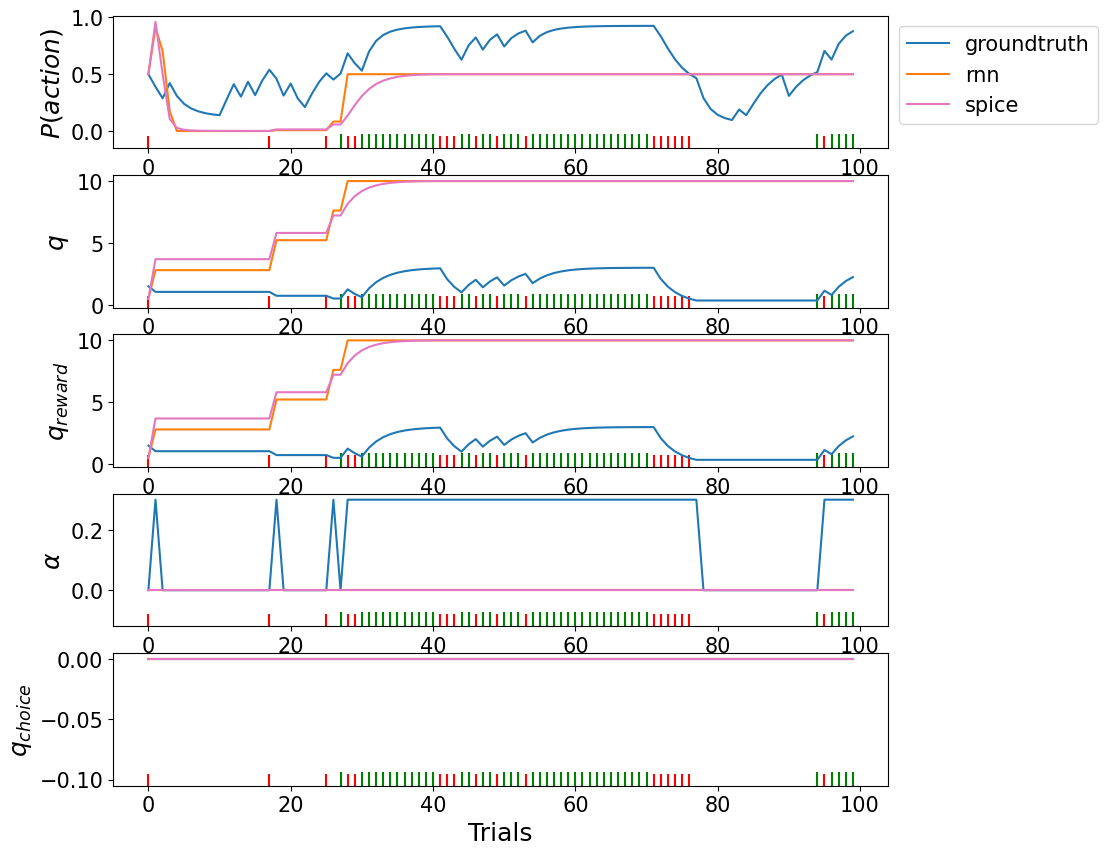

In [9]:
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent, 'rnn': spice_estimator.rnn_agent, 'spice': spice_estimator.spice_agent}

fig, axs = plot_session(agents, dataset.xs[0])
plt.show()

## 3. Implementing the RNN as a custom module

In this section we are going to implement the precoded RNN from scratch.

This RNN will inherit from the `BaseRNN`-class which itself inherits from `pytorch.nn.Module`. This is the base class for neural networks in the `PyTorch` framework.

Therefore the RNN has to implement a `forward`-method which is used for prediction. Further, it needs submodules to perform computations. These submodules are stored in the dictionary ` submodules_rnn` with the key `x_ModuleName`. The start of the key `x_` means that we are talking here about a memory state variable of the RNN.

Here, we are going to implement the simplest version of such a RNN. This RNN will update only the value of the chosen option based on the reward and leaves the values of the not chosen options untouched.

In [10]:
from spice.resources.rnn import BaseRNN

class CustomRNN(BaseRNN):
    
    # set up a dictionary with initial values for each state in memory
    init_values = {
        'x_value_reward': 0.5,
    }
    
    def __init__(
        self,
        n_actions,
        **kwargs,
    ):   
        super(CustomRNN, self).__init__(n_actions=n_actions, list_signals=['x_value_reward_chosen', 'c_action', 'c_reward'])
        
        # set up the submodules
        self.submodules_rnn['x_value_reward_chosen'] = self.setup_module(input_size=1)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, ids, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _, _ = inputs
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('x_value_reward_chosen', self.state['x_value_reward'])
            
            # Let's perform the belief update for the reward-based value of the chosen option
            # since all values are given to the rnn-module (independent of each other), the chosen value is selected by setting the action to the chosen one
            # if we would like to perform a similar update by calling a rnn-module for the non-chosen action, we would set the parameter to action=1-action.
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=reward,
                )

            # and keep the value of the not-chosen option unchanged
            next_value_reward_not_chosen = self.state['x_value_reward'] * (1-action)
            
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen  # memory state = (0.8, 0.3) <- next_value = (0.8, 0) + (0, 0.3)
            
            # Now keep track of this value in the output array
            logits[timestep] = self.state['x_value_reward']
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        # self.state['x_value_reward'] = value_reward
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

Now that we implemented our RNN, we can train it to see how well it fits the behavior of our synthetic participant.

In [11]:
from spice.estimator import SpiceConfig

custom_config = SpiceConfig(
    # A list of all names of the RNN-modules which are computing the RNN's memory state
    rnn_modules=['x_value_reward_chosen'],

    # A list of all the control signals which are used as inputs to any of the RNN-modules
    control_parameters=['c_action', 'c_reward'],

    # Setup of the SINDy library
    # Determines which terms are allowed as control inputs to each SINDy model in a dictionary.
    # The key is the SINDy-model name (same as RNN-module), value is a list of allowed control inputs from the list of control signals 
    library_setup={
        'x_value_reward_chosen': ['c_reward'],
    },

    # Setup of the filtering condition
    # Determines the filtering condition on which samples are selected as training samples for each SINDy-model.
    # Example:
    # Since each RNN-module processes all values at once (but independet from each other), we have to filter for the updates of interest.
    # In the case of the reward-based value of the chosen option this means to use only the chosen items and not the non-chosen ones. 
    # Therefore, we can set a filter condition to get rid of all value updates for non-chosen options.  
    # The filter dictionary has the following structure:
    # key -> the SINDy model name
    # value -> triplet of values:
    #   1. str: feature name to be used as a filter
    #   2. numeric: the numeric filter condition
    #   3. bool: remove feature from control inputs if not needed as input to the module
    # Multiple conditions can also be given as a list of triplets, e.g. [['c_action', 1, True], ['c_reward', 0, False]]
    filter_setup={
        'x_value_reward_chosen': ['c_action', 1, True],
    },
)

Library setup is valid. All keys and features appear in the provided list of features.


In [12]:
from spice.estimator import SpiceEstimator


custom_spice_estimator = SpiceEstimator(
    rnn_class=CustomRNN,
    spice_config=custom_config,
    learning_rate=5e-3,
    epochs=1024,
    n_steps_per_call=16,
    spice_participant_id=0,
    verbose=True,
)

custom_spice_estimator.fit(dataset.xs, dataset.ys)

TypeError: SpiceEstimator.__init__() got an unexpected keyword argument 'spice_participant_id'

Let's see how our model behaves with respect to our synthetic participant.

In the following plot you can compare the action probabilities P(action), the Q-Value, the reward-based as well as the choice-based values.
(You can ignore for now the learning rate $\alpha$)

After initializing and fitting the SINDy-agent, we can now finally inspect whether all these steps resulted in well identified cognitive dynamics!

In [ ]:
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent, 'rnn': custom_spice_estimator.rnn_agent, 'spice': custom_spice_estimator.spice_agent}

fig, axs = plot_session(agents, dataset.xs[0])
plt.show()

## Saving and loading models

Below is how you can save and load SPICE models. You can specify `path_rnn`, `path_spice` or both to save or load either or both of them.

In [ ]:
# Save trained model to file
spice_estimator.save_spice(path_rnn='rnn_model.pkl', path_spice='spice_model.pkl')

# Load saved model
loaded_spice = SpiceEstimator(
    rnn_class=CustomRNN,
    spice_config=custom_config,
    learning_rate=5e-3,
    epochs=1024,
    n_steps_per_call=16,
    spice_participant_id=0,
    verbose=True,
)
loaded_spice.load_spice(path_rnn='rnn_model.pkl', path_spice='spice_model.pkl')


In [ ]:
# Use loaded model for predictions
pred_rnn, pred_spice = spice_estimator.predict(dataset.xs)